In [2]:
from tools import datacleaner as dtclean
from tools import dataexplore as dtexp
from view import data_visualization as dtview
import pandas as pd
import numpy as np
from fbprophet import Prophet
from evaluation import forecast_metrics as fm
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools
import matplotlib.pyplot as plt
# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import warnings

warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

# **Análise dos dados de vendas da loja 274**


<div class="alert alert-block alert-warning">
<b>Obs:</b> Na análise dos dados identificamos incosistências que podem comprometer a performance dos modelos
gerados nesse trabalho. Para mitigar esse impacto foram feitas análises sobre os dados agregados ao dia e por hora.
Esse notebook inicia a apresentação dos dados agregados ao dia.
</div>
As inconsistências serão devidamente apresentadas no modelo agregado por hora.

In [3]:
df_274_sale = dtclean.get_Dataframes(274,'s')
df_274_sale.reset_index(inplace=True)

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [4]:
print('Data início: {}, Data final: {}'.format(df_274_sale.ds.min(),df_274_sale.ds.max()))
df_274_sale.info()

Data início: 2020-03-01 00:00:00, Data final: 2020-05-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      92 non-null     datetime64[ns]
 1   y       92 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
iplot(dtview.plot_scatter(df_274_sale,title='Produtos vendidos'))

<div class="alert alert-block alert-info">
<b>Obs:</b> Notamos nesse gráfico que há um pico de vendas de produtos no mês de março e uma queda significativa no fim
do mês de maio. Na celula abaixo criamos um modelo sem promover afinamentos para efeitos de comparação.
</div>


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


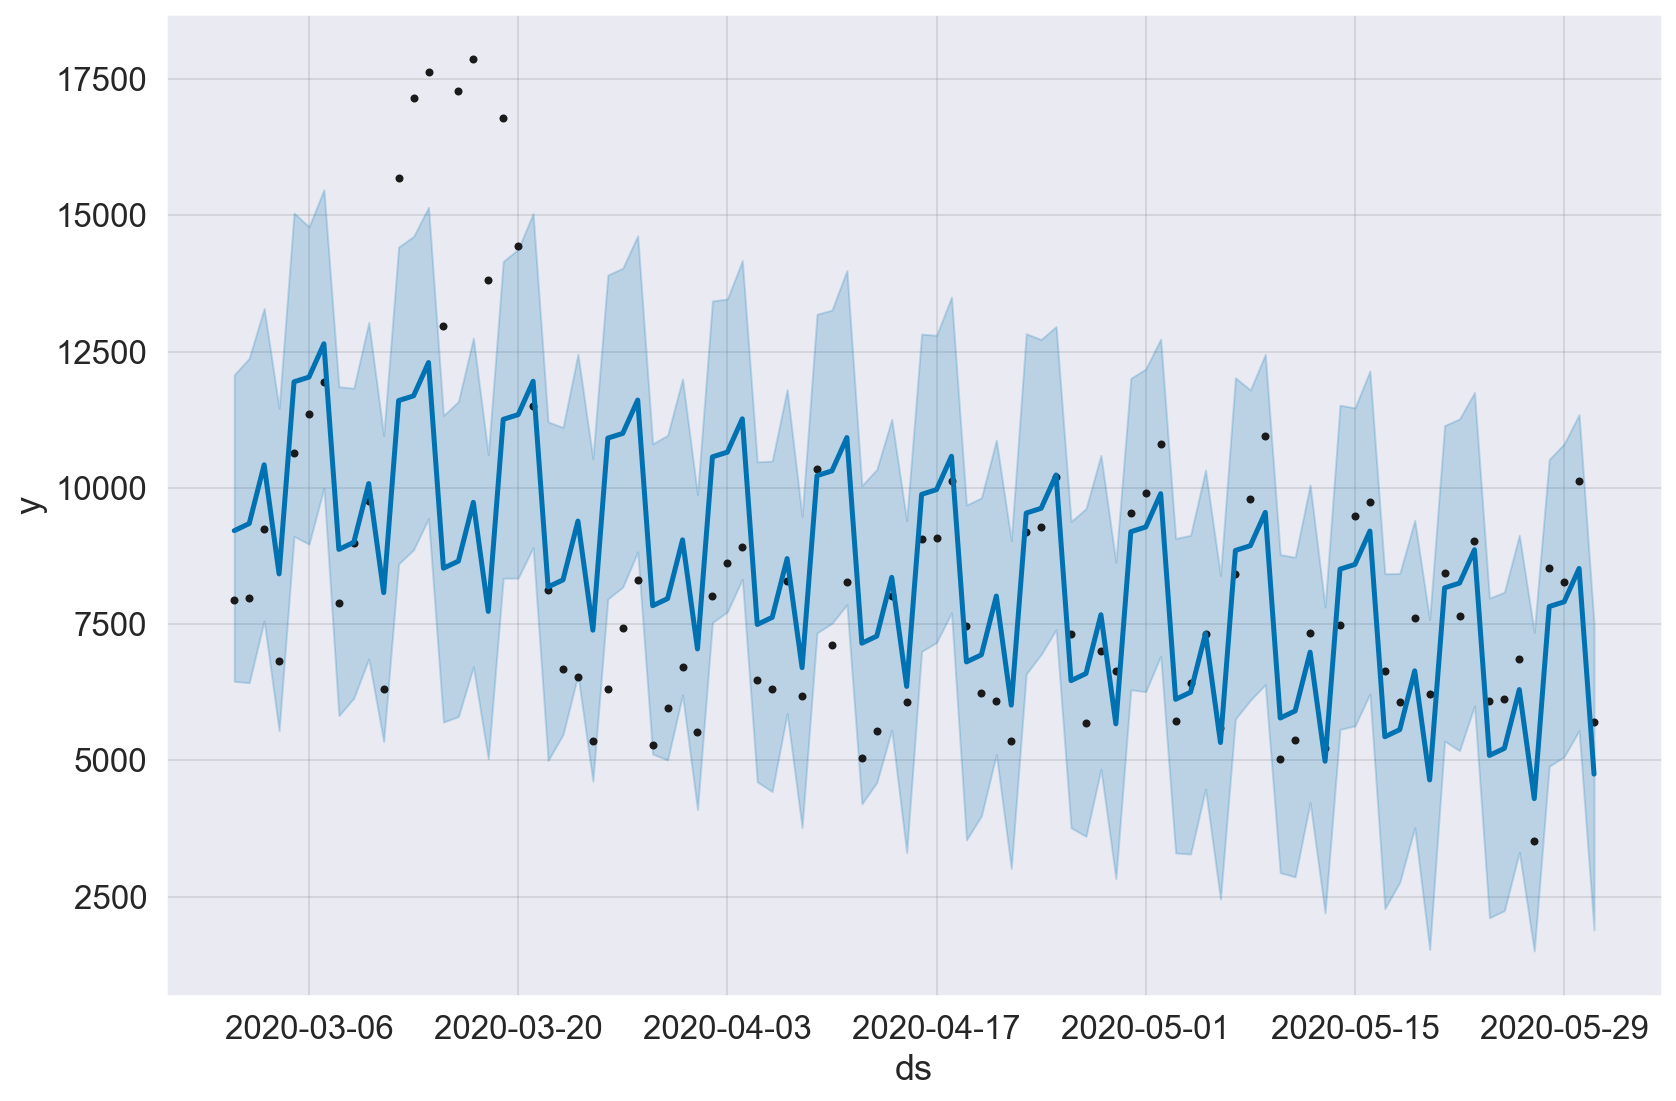

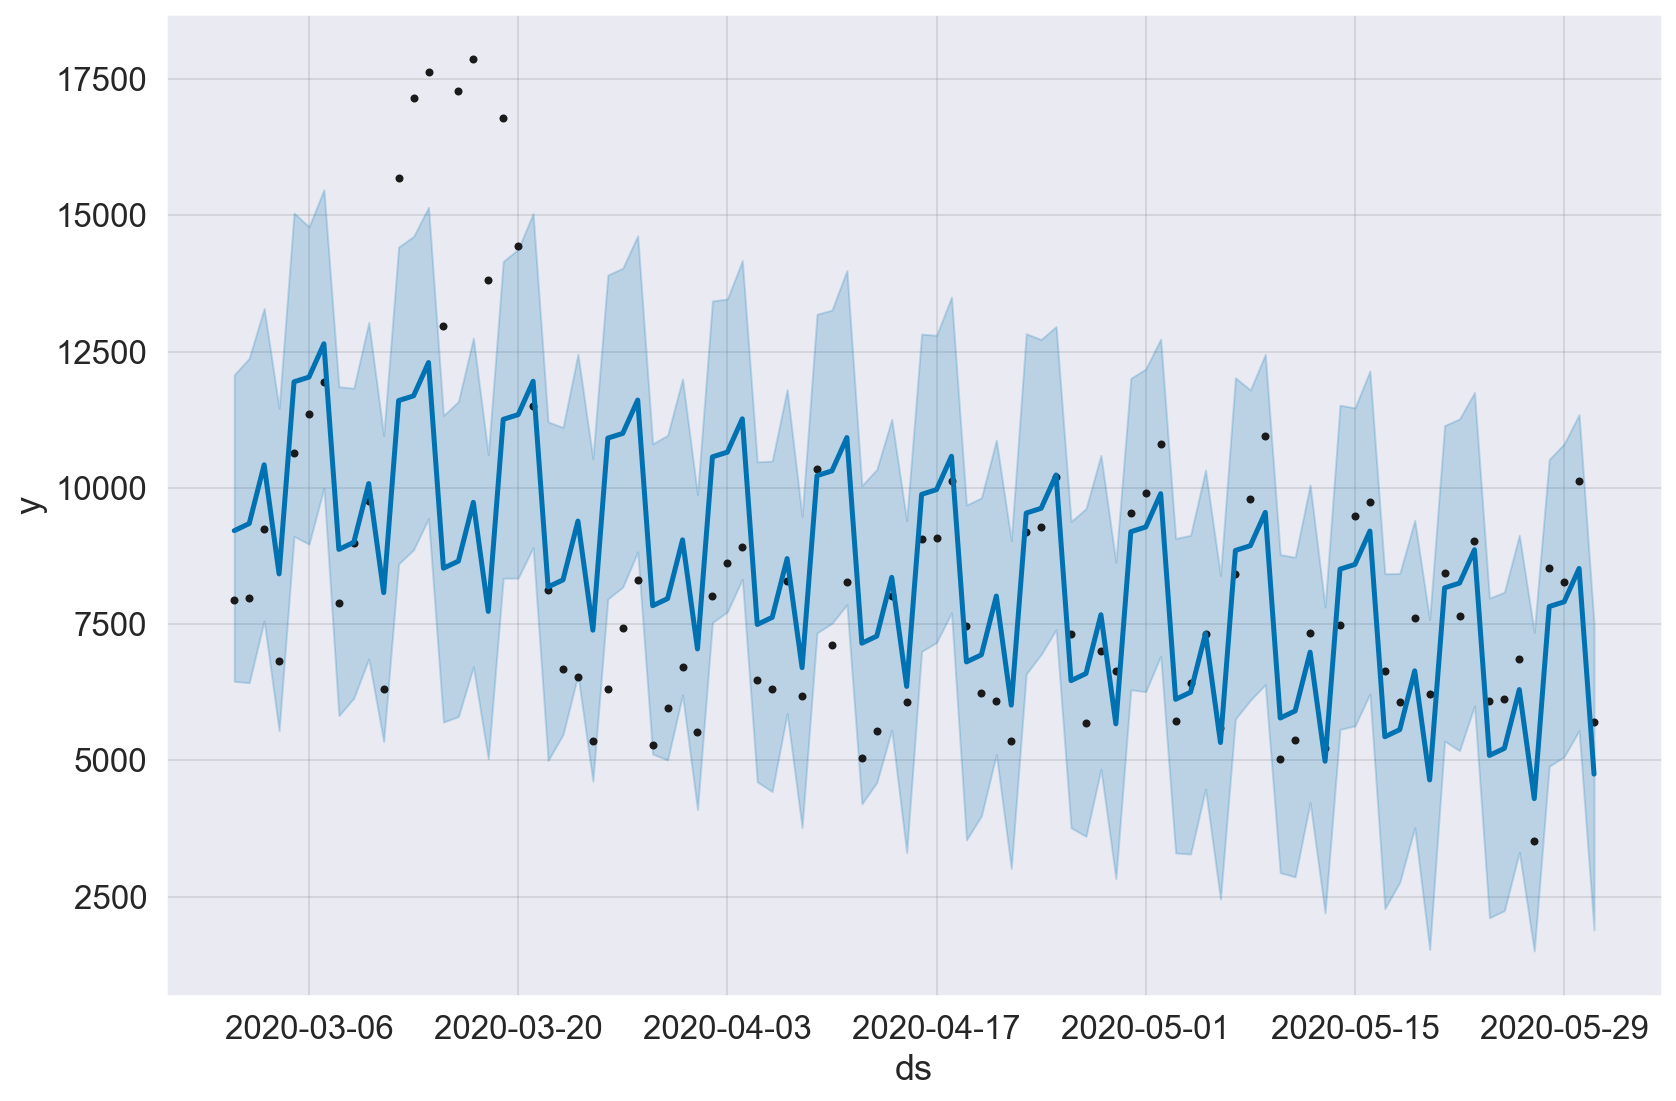

In [6]:
model = Prophet()
model.fit(df_274_sale)
forecast = model.predict(df_274_sale)
model.plot(forecast,figsize=(12,8))

### Análise dos Dados - Dividimos os dados para observar com maior detalhe a distribuição da quantidade de produtos vendidos ao longo das semanas e dias.

In [6]:
df_new = dtexp.date_features(df_274_sale)
mesAgregado = pd.DataFrame(df_new.groupby("semana")["y"].sum()).reset_index().sort_values('y')
semanaAgregada = pd.DataFrame(df_new.groupby("num")["y"].sum()).reset_index().sort_values('num')
iplot(dtview.plot_dados_agregados_semana_mes(mesAgregado,tipo_agregacao='m',xaxes_title='Nº da semana',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por Semana'))
iplot(dtview.plot_dados_agregados_semana_mes(semanaAgregada,xaxes_title='Nº do dia (0 = Domingo, 1 = Segunda ...)',yaxis_title='Total de produtos vendidos',
                                      title='Vendas por dia'))

<div class="alert alert-block alert-info">
<b>Vendas por Semana:</b> Mensalmente há, conforme já observado, um pico de produtos vendidos entre a 9ª e a 11ª semana de 2020,
que corresponde ao período de 24de fevereiro à 15 de março, contudo nossos dados começam em 01 de março.
Destaca-se a última semana (22ª) como a de menor volume de produtos vendidos.
<p><b>Vendas por Dia:</b> No volume de vendas diárias nota-se que a quarta-feira é o dia de menor volume de vendas, e,
a partir da quinta-feira há um salto no volume de vendas com o pico ocorrendo no sábado.</p>
<p><b>Dados de Treino e de Testes:</b> A partir dessa análise foram gerados os datasets de treino e de testes,
numa relação 90/10 respetivamente.</p>
</div>

In [7]:
df_274_sale_treino_diario, df_274_sale_teste_diario = dtexp.configura_dataframe_treino_teste(df_274_sale)
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sale_treino_diario.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sale_teste_diario.shape))
print('-'*60)

------------------------------------------------------------
Shape dataframe de treino --> (84, 2)
Shape dataframe de teste --> (8, 2)
------------------------------------------------------------


## Visualizando a representação dos datasets de treino e de teste sobre o montante total.

In [8]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_treino_diario,
                                   df_274_sale_teste_diario,
                                   title='Montante de dados de vendas de Treinamento e Teste',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [9]:
prophet = Prophet()
prophet.fit(df_274_sale_treino_diario)
future_vendas = prophet.make_future_dataframe(periods=7, freq='D')
forecast_vendas = prophet.predict(future_vendas)
#iplot(dtview.plot_forecast_as_table(forecast_vendas))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


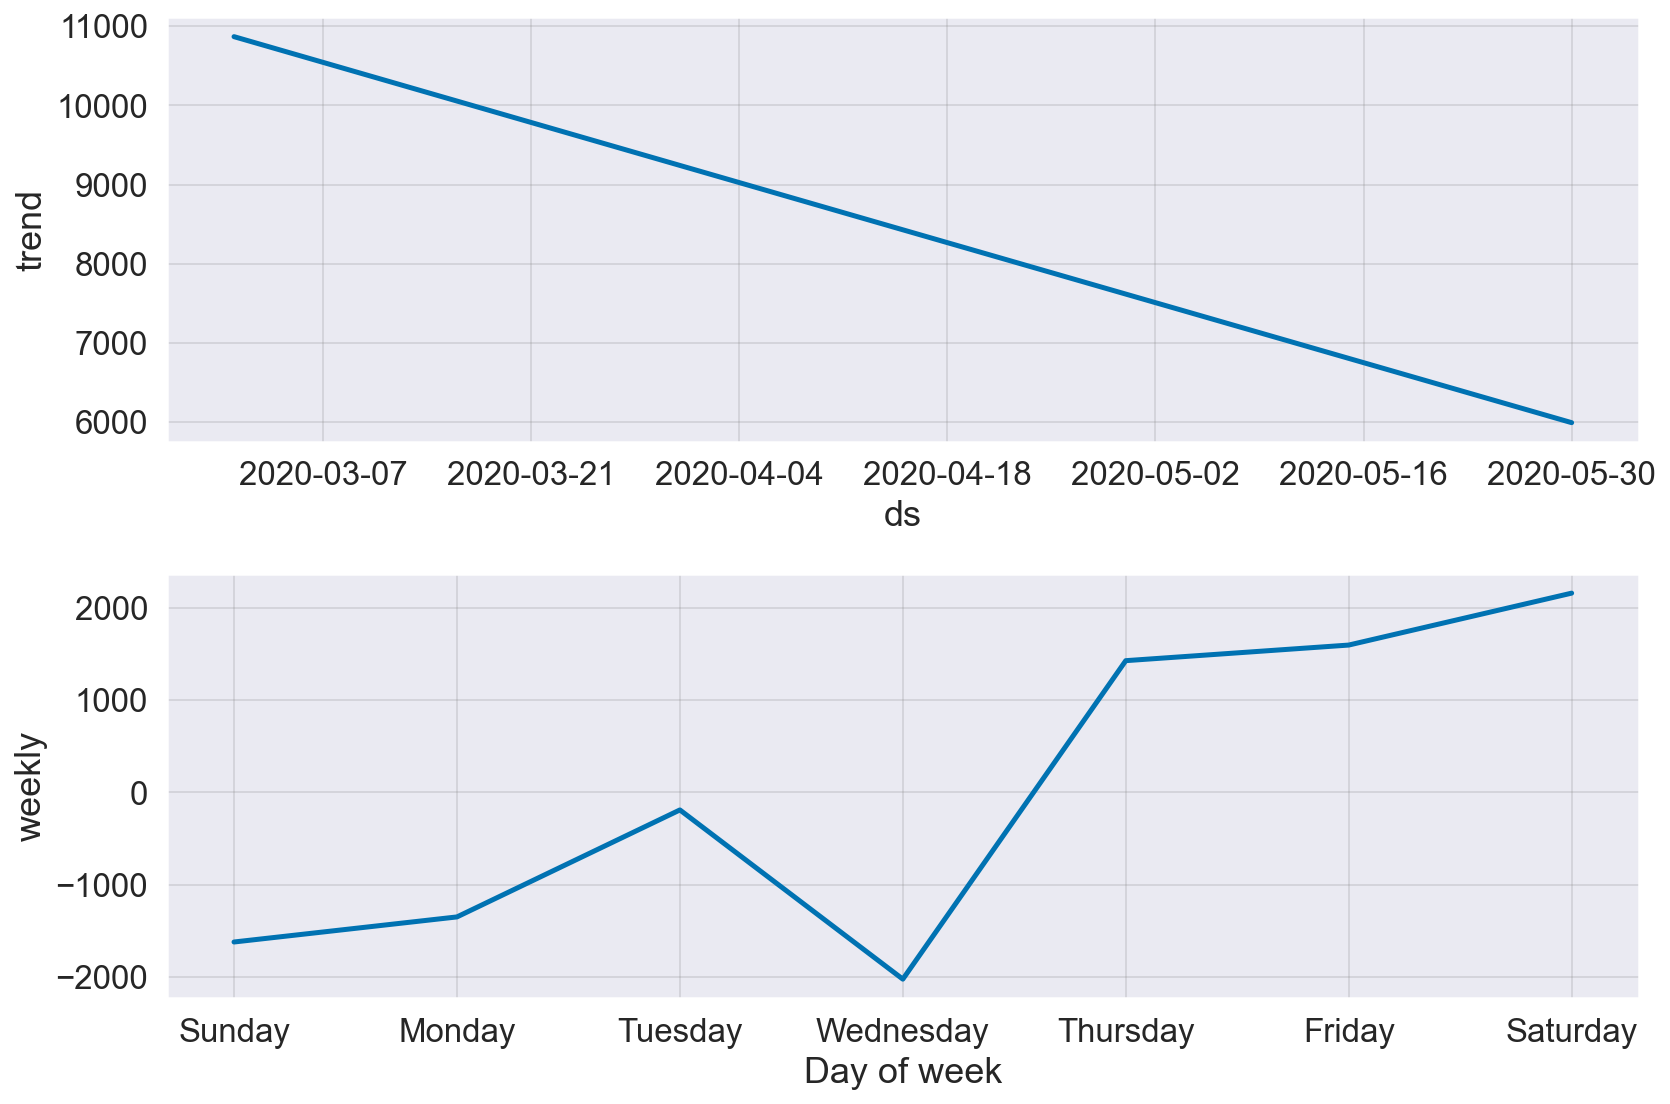

In [10]:
fig = prophet.plot_components(forecast_vendas, figsize=(12,8))


# Modelo Baseado na Decomposição dos Componentes

<div class="alert alert-block alert-info">
<b>Tendência:</b> Os dados apresentam uma tendência de queda da quantidade de produtos vendidos.
<p><b>Componente Semanal:</b> Nesse componente observamos um volume negativo de produtos vendidos entre domingo e quarta.
Isso ocorre em função da sazonalidade semanal e diária que ainda não foi identificada corretamente e as grandes
variações nas quantidades de produtos vendidos entre os meses de março e os seguintes. Esses fatores podem ser os que
apresentam maior influência nesses resultados. Notamos que a quarta-feira, no modelo previsto, mantém o comportamento
identificado anteriormente nos dados reais.</p>
</div>

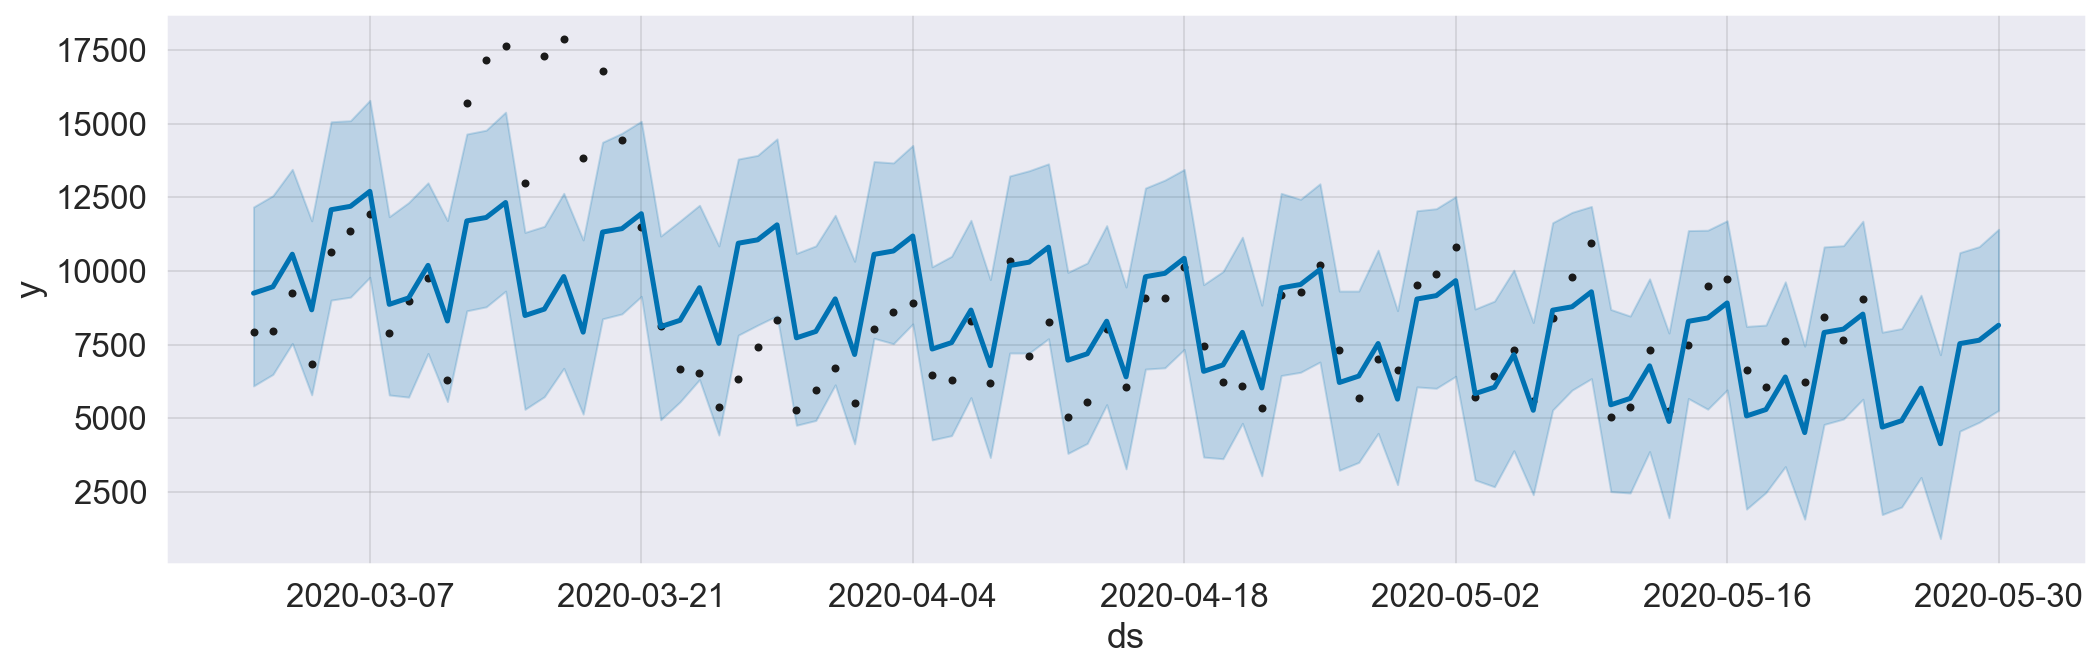

In [11]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet.plot(forecast_vendas,ax=ax)
plt.show()

<div class="alert alert-block alert-info">
<b>Gráfico do modelo previsto:</b> Os pontos escuros no gráfico representam os dados reais e na altura da segunda semana
de março, observamos dados que escapam do modelo previsto indicando possíveis outliers. As linhas azuis mais escura,
representam a previsão de volumes de produtos vendidos enquanto as linhas mais claras representam o intervalo de
confiança em torno da previsão.
</div>

In [12]:
df_274_sale_teste_diario_forecast = prophet.predict(df_274_sale_teste_diario)
iplot(dtview.plot_forecast_as_table(df_274_sale_teste_diario_forecast))

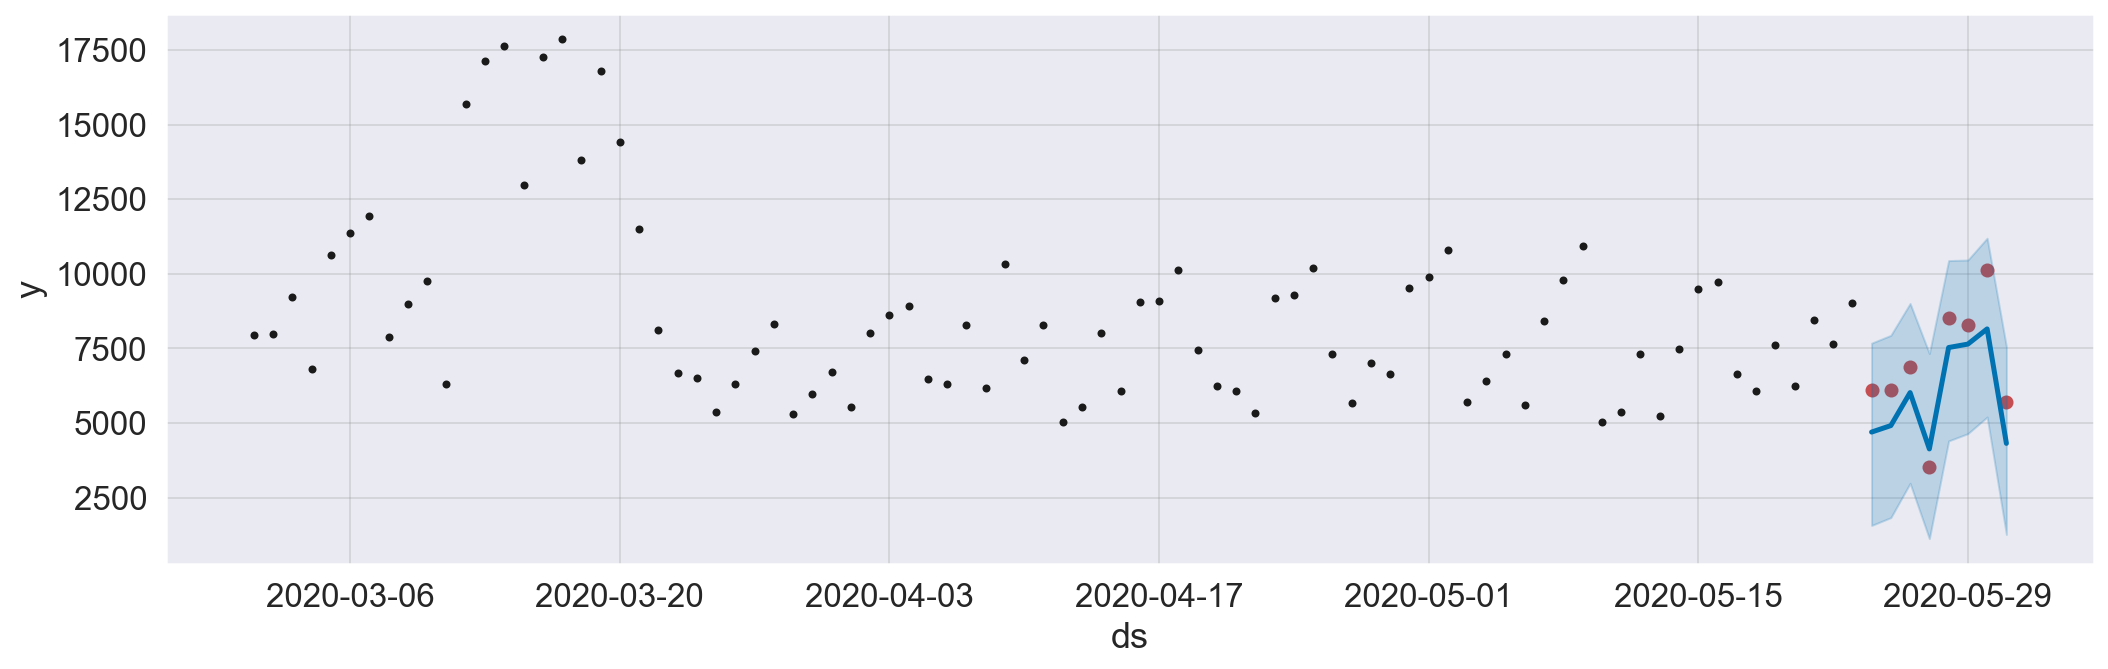

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds,df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast,ax=ax)
plt.show()


# Comparação entre as vendas do dataset previsto e as vendas do dataset de teste (vendas realizadas)

In [14]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_274_sale_teste_diario_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

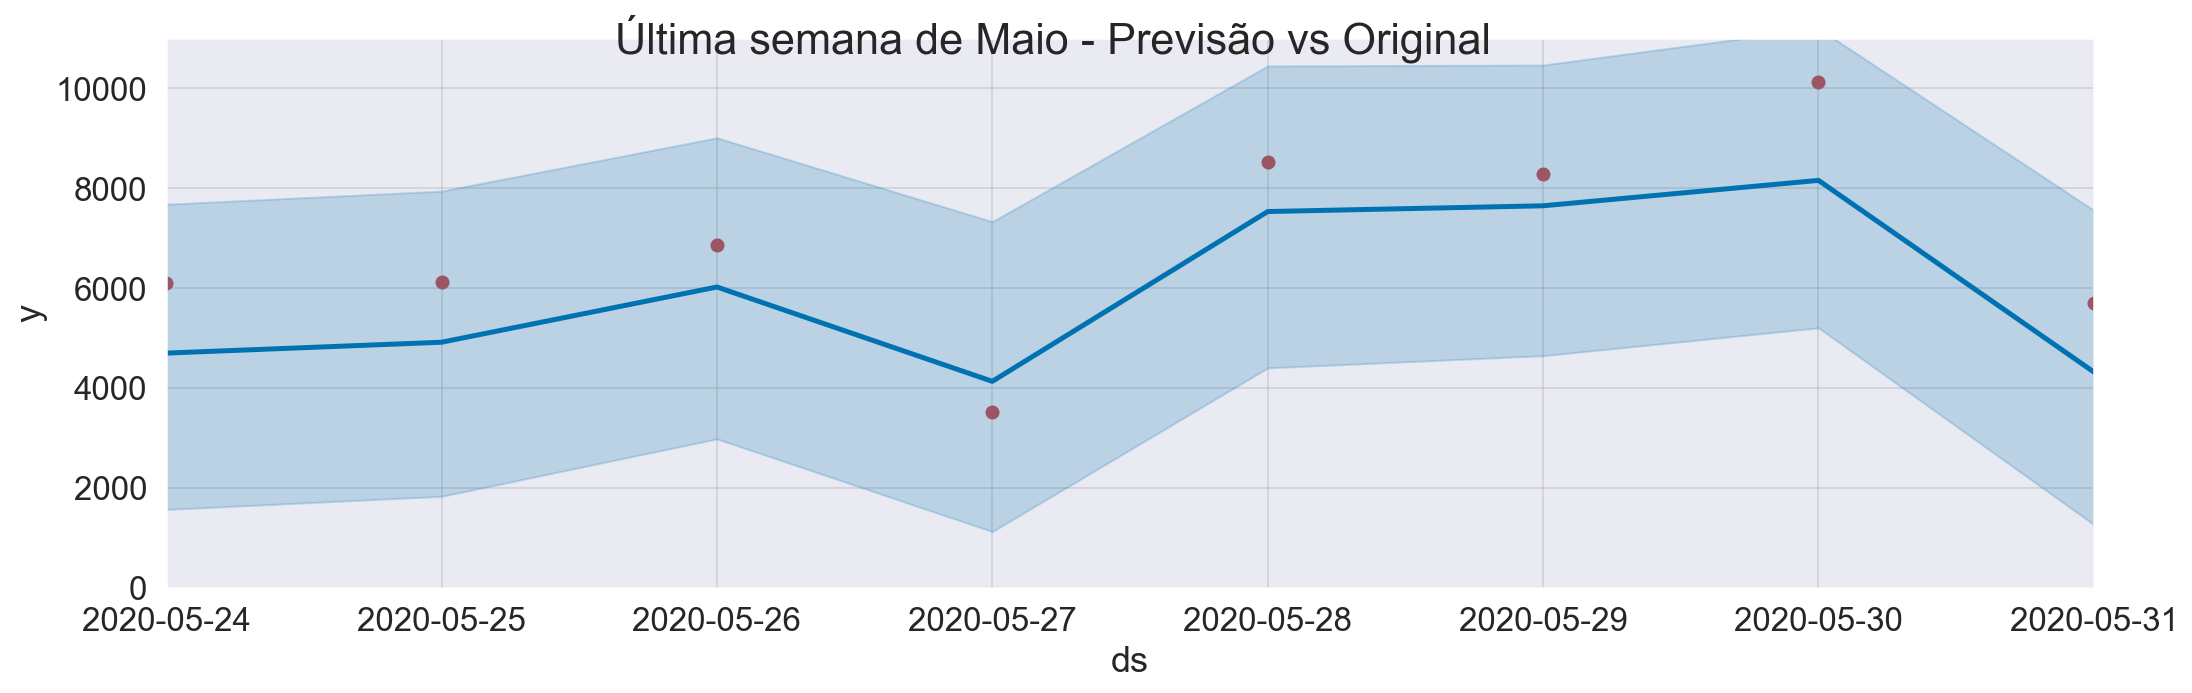

In [15]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sale_teste_diario.ds, df_274_sale_teste_diario['y'], color='r')
fig = prophet.plot(df_274_sale_teste_diario_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 11000)
plot = plt.suptitle('Última semana de Maio - Previsão vs Original')

In [16]:
mape_analysis = []
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario['y']),
                                       np.array(df_274_sale_teste_diario_forecast['yhat'])))
print("MAPE ------> {}".format(mape_analysis[0]))


MAPE ------> 0.16899542665715367


In [17]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_274_sale_teste_diario_forecast,
    nametrace1='Valor Real',
    nametrace2='Valor Previsto',
    idx_end=28))

# Criando novo modelo com os feriados

<div class="alert alert-block alert-info">
<b>Adicionando feriados ao modelo:</b> Vamos verificar se há melhora no MAPE com os feriados adicionados ao novo modelo.
</div>

In [18]:

prophet_feriados = Prophet(holidays=dtclean.get_Holiday())
prophet_feriados.add_country_holidays('BR')
prophet_feriados.fit(df_274_sale_treino_diario)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados = prophet_feriados.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados = prophet_feriados.predict(future_feriados)
# Previsão optimizada dos valores
forecast_feriados = prophet_feriados.predict(future_feriados)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


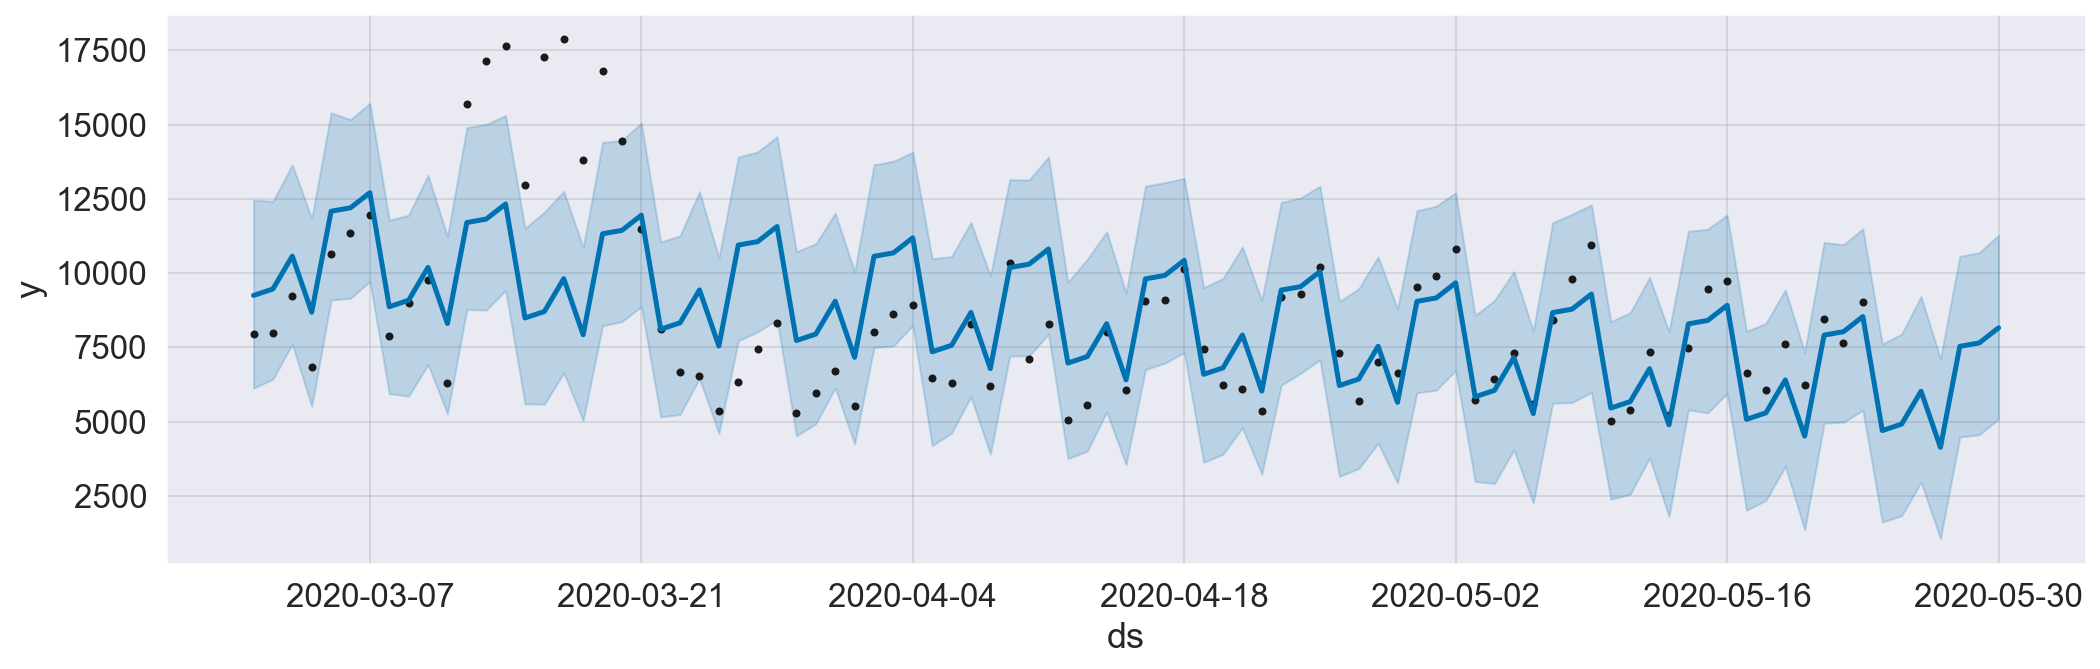

In [19]:
plt,fig_forecast_feriado = dtview.plot_forecast(forecast_feriados,prophet_feriados,f,ax)
plt.show()

<div class="alert alert-block alert-info">
Visualmente não notamos grandes diferenças no gráfico previsto para o novo modelo gerado com feriados. Cabe destacar
que não sabemos os feriados específicos da cidade e sequer eventos que possam impactar na variável em análise, como
dias de jogos de futebol, eventos festivos e etc.
</div>

# Visualizando os componentes do modelo

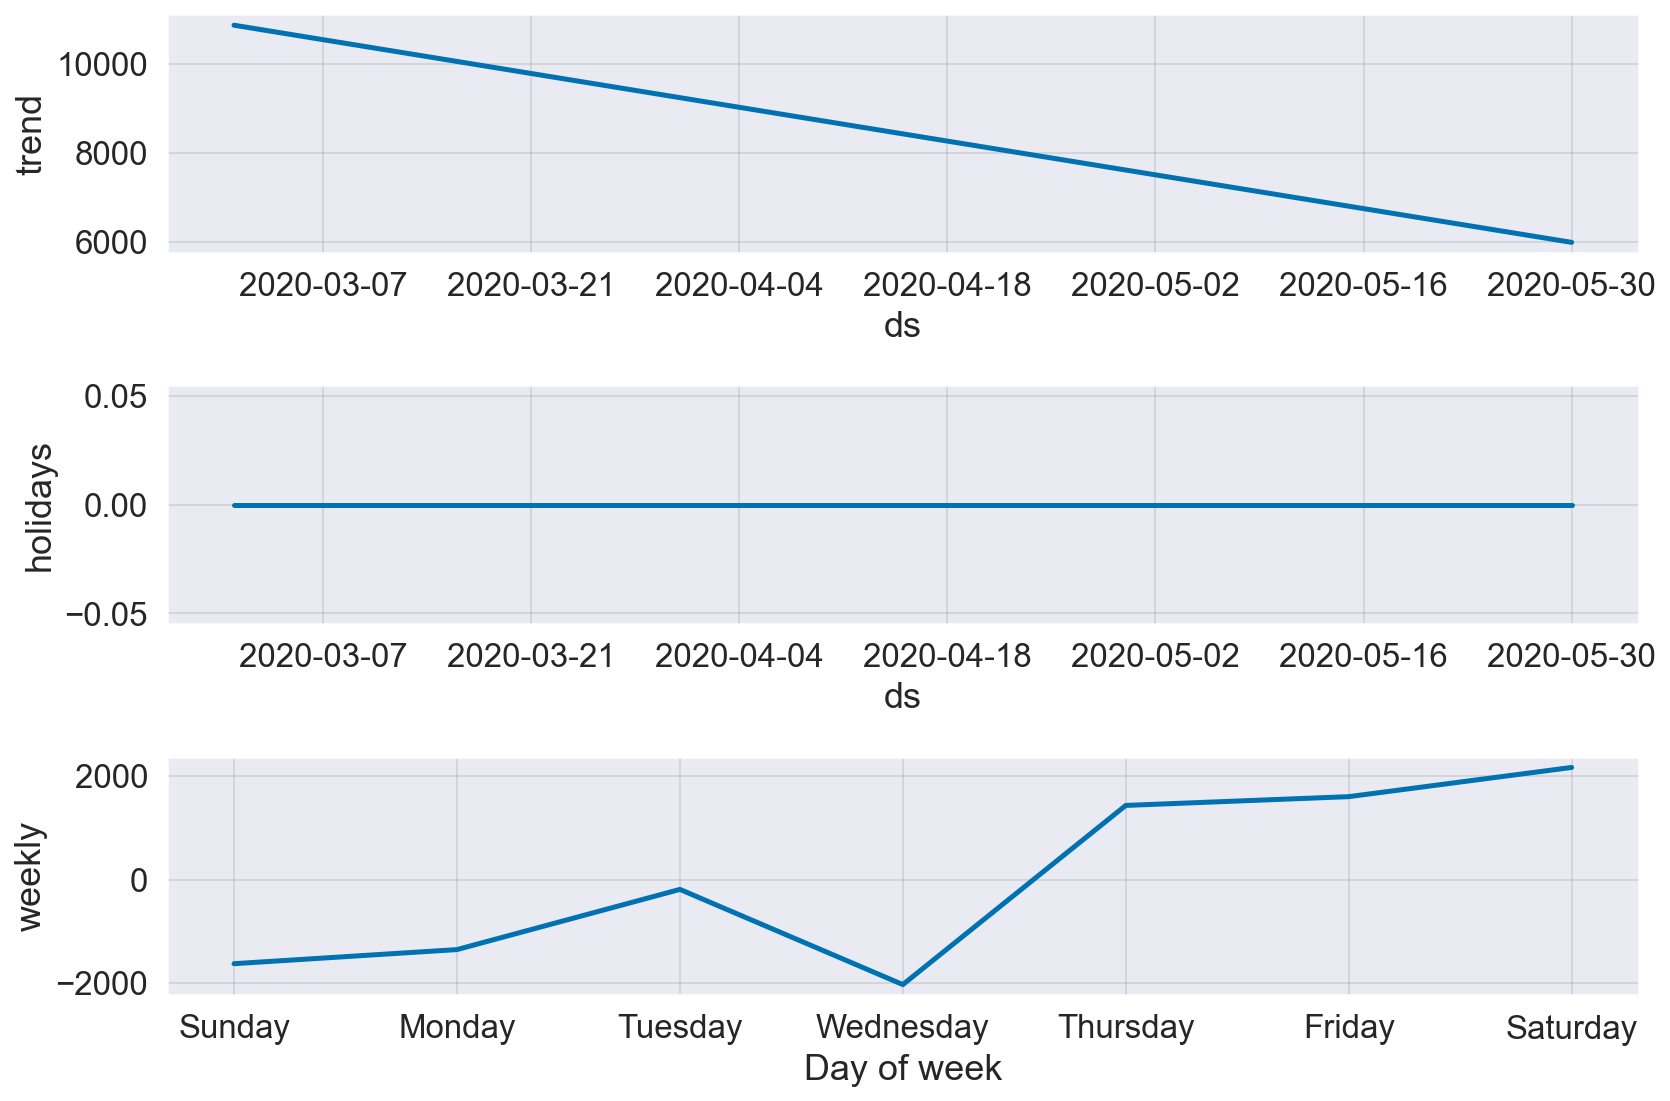

In [20]:
fig_forecast_feriado = prophet_feriados.plot_components(forecast_feriados, figsize=(12,8))

<div class="alert alert-block alert-info">
<b>Componentes:</b> Também não há diferenças nos gráficos de componentes de tendência e semanal, apenas há um novo
componente que representa o feriado onde se espera que não haja vendas nesses dias, contudo, isso pode representar
exatamente o oposto, isto é, a loja funciona nos feriados e há um volume de vendas razoável nos dias que antecedem
o feriado, é preciso saber essa informações para adaptar o modelo.
</div>

In [21]:
forecast_teste_feriados = prophet_feriados.predict(df_274_sale_teste_diario)

## Visualizar dataframe de teste previsto e original com feriados

In [22]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sale_teste_diario,
    forecast_teste_feriados,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [23]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(forecast_teste_feriados.yhat)))
print("MAPE ------> {}".format(mape_analysis[1]))

MAPE ------> 0.16899542665714887


<div class="alert alert-block alert-info">
Conforme podemos verificar pelo resultado do MAPE, a adição dos feriados não ocasionaram impactos dignos de nota.
</div>

## Realizando tunning nos parâmetros do modelo para melhorar a acurácia.

<div class="alert alert-block alert-info">
Fazemos uma verificação de combinações possíveis de alguns dos parâmetros utilizados pelo Prophet para identificar a
combinação que poderá oferecer melhor acurácia do modelo. Cabe destacar aqui que não foram explorados todos os
parâmetros, visto que há necessidade de obter maiores detalhes com os business experts sobre questões como outliers,
feriados, horários de abertura e encerramento da loja e etc.
</div>

In [24]:
from sklearn.model_selection import ParameterGrid
changepoint = [0.3,0.5,10]
seasonality_prior = [15,20,25]
holidays_prior = [0.3,0.5,10]
n_change = [30,50,66]

params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':changepoint,
               'seasonality_prior_scale': seasonality_prior,
              'holidays_prior_scale':holidays_prior,
              'n_changepoints' : n_change}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 162


In [25]:
iplot(dtview.view_optimum_parameters('model_parameters_274_vendas_diarias.csv'))

In [ ]:
'''Utilizar apenas quando prever melhor conjunto de parâmetros. Acessar o arquivo model_parameters_274_vendas.csv'''
dtexp.tuning_model(df_274_sale_treino_diario,df_274_sale,periodo=7,frequencia='D',loja='274',tipo='vendas_diarias',
                   changepoint_prior_scale=[0.3,0.5,10],
                   seasonality_prior_scale=[15,20,25],
                   holidays_prior_scale=[0.3,0.5,10])

{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.8200929748480625
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.8200929748480625
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.8200929748480625
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.7076916607666385
{'changepoint_prior_scale'

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.7077316035306679
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.7077316035306679
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 10, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4104076293898816
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 10, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4104076293898816
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 10, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Erro

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4335355449547185
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.707668988288893
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.707668988288893
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.707668988288893
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)-----

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.43353890930140915
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.43353890930140915
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.43353890930140915
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.7076689882871291
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MA

Mean Absolute Percentage Error(MAPE)------------------------------------ 0.640826676706996
{'changepoint_prior_scale': 10, 'holidays_prior_scale': 0.5, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4268094442973784
{'changepoint_prior_scale': 10, 'holidays_prior_scale': 0.5, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4268094442973784
{'changepoint_prior_scale': 10, 'holidays_prior_scale': 0.5, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4268094442973784
{'changepoint_prior_scale': 10, 'holidays_prior_scale': 0.5, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(

## Treinando o modelo com os melhores parâmetros identificados

+ changepoint_prior_scale= 10
+ holidays_prior_scale = 0.3
+ n_changepoints = 30
+ seasonality_mode = 'multiplicative'
+ seasonality_prior_scale = 15,20,25

In [29]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 15,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet.add_country_holidays(country_name='BR')
final_prophet.fit(df_274_sale_treino_diario)

In [30]:
future_final = final_prophet.make_future_dataframe(periods=7, freq='D')
forecast_final = final_prophet.predict(future_final)

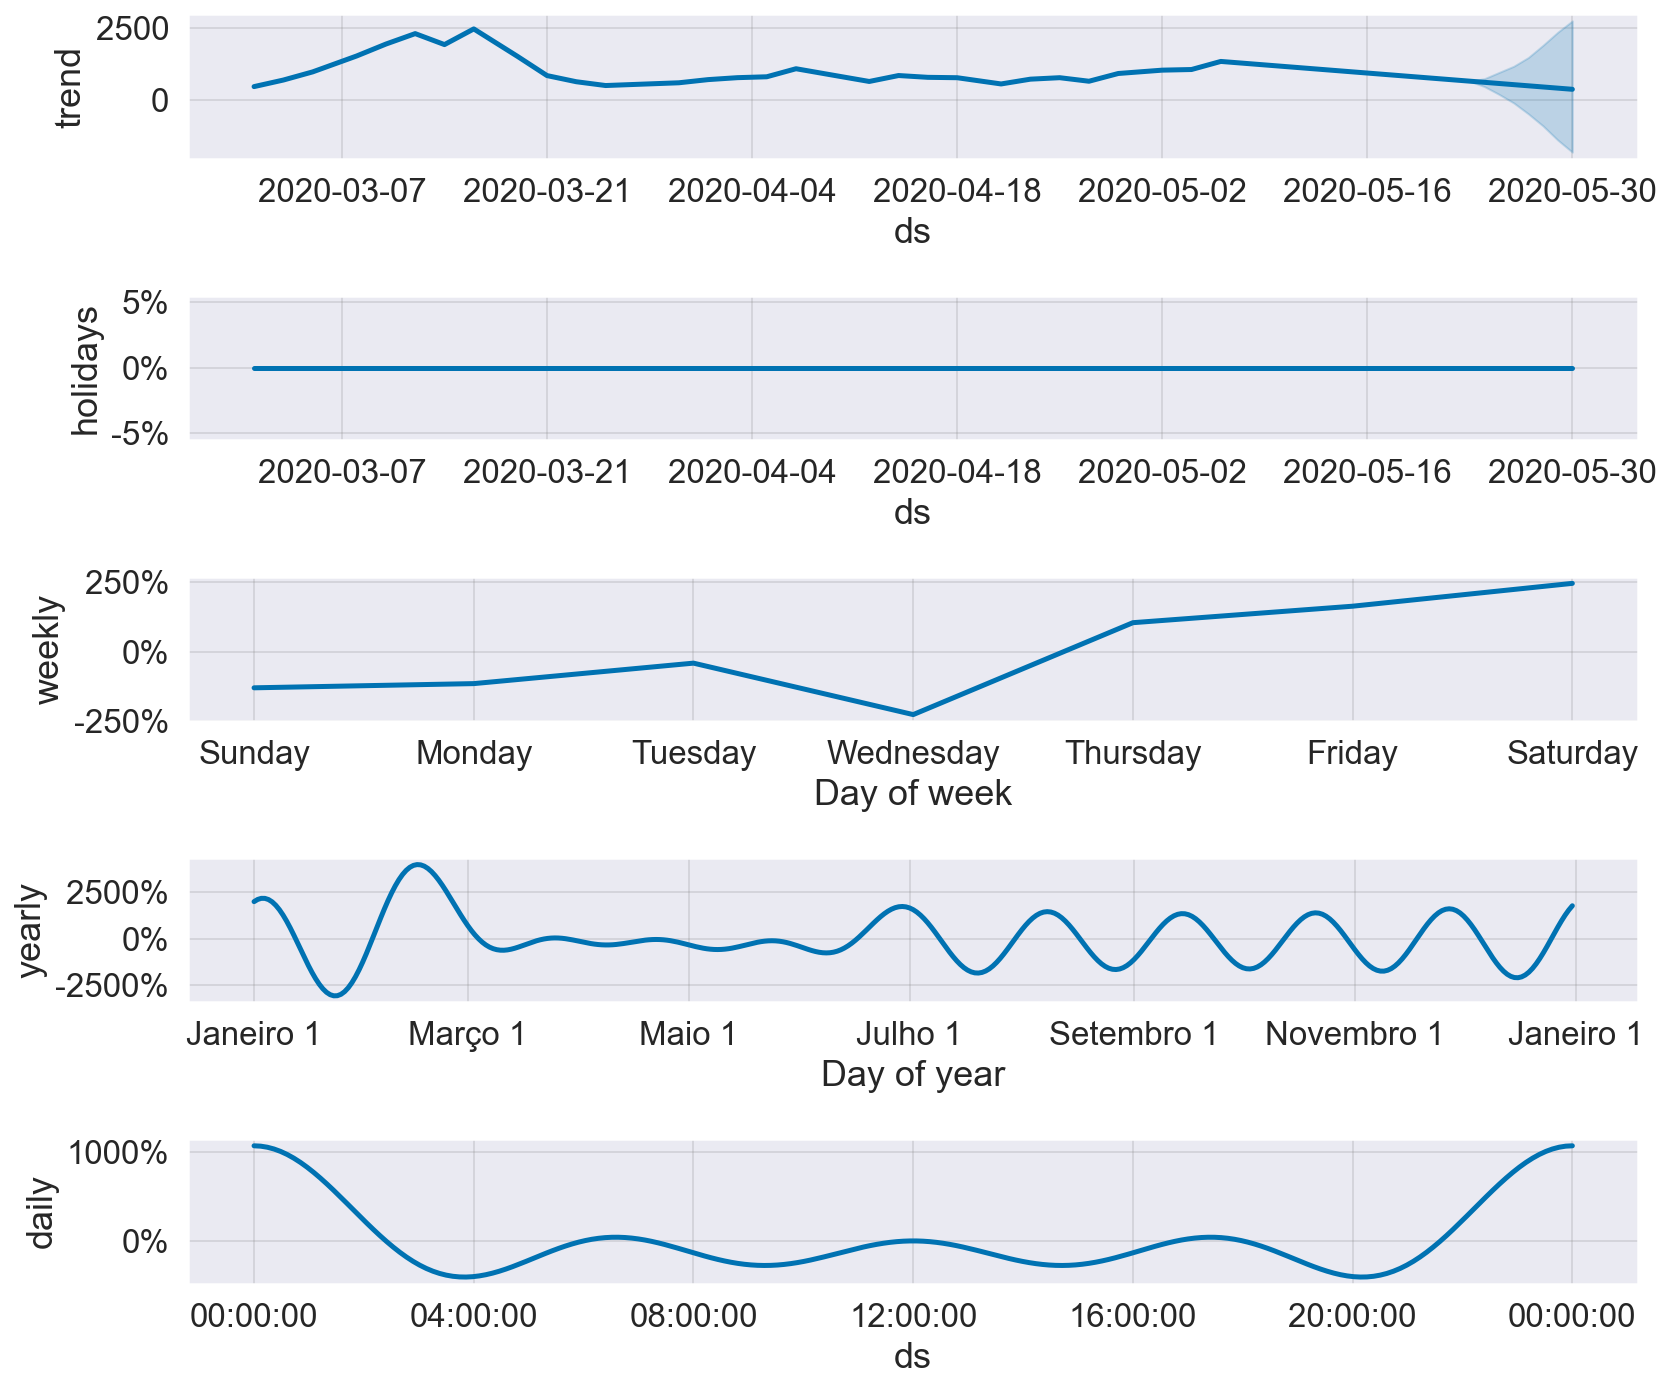

In [31]:
# Plot the components of the model
fig = final_prophet.plot_components(forecast_final, figsize=(12,10))

<div class="alert alert-block alert-info">
Na plotagem dos componentes, observamos que o eixo y teve uma redução. Esse eixo representa o quanto o dia da semana
afeta ou impacta na previsão, antes dos parâmetros tunados e sem adição dos feriados, era superior a 2000 % e agora
reduziu para 250%. Entre domingo e quinta-feira há uma variação que supera 250% para a sazonalidade semanal e
na sazonalidade anual, há uma variação superior a 5000% entre fevereiro em março, essas variações são as responsáveis
por verificarmos valores negativos na previsão. Um teste para tratar essa situaçõa poderá ser separar o dataset em semana
útil e fins de semana, para verificar se há melhora na acurácia e remoção dos valores negativos.
</div>

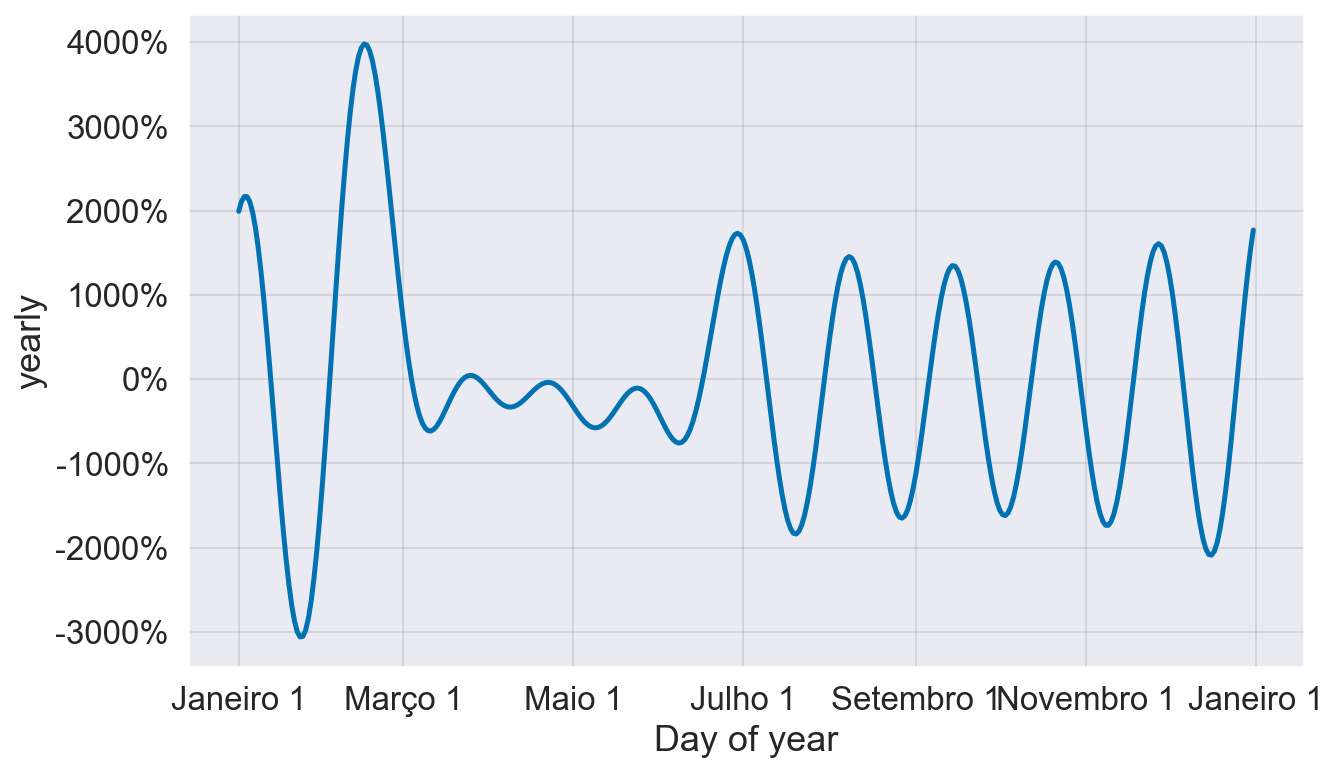

In [32]:
from fbprophet.plot import plot_weekly,plot_yearly, plot_seasonality,plot_seasonality_plotly

fig_y = plot_yearly(final_prophet)


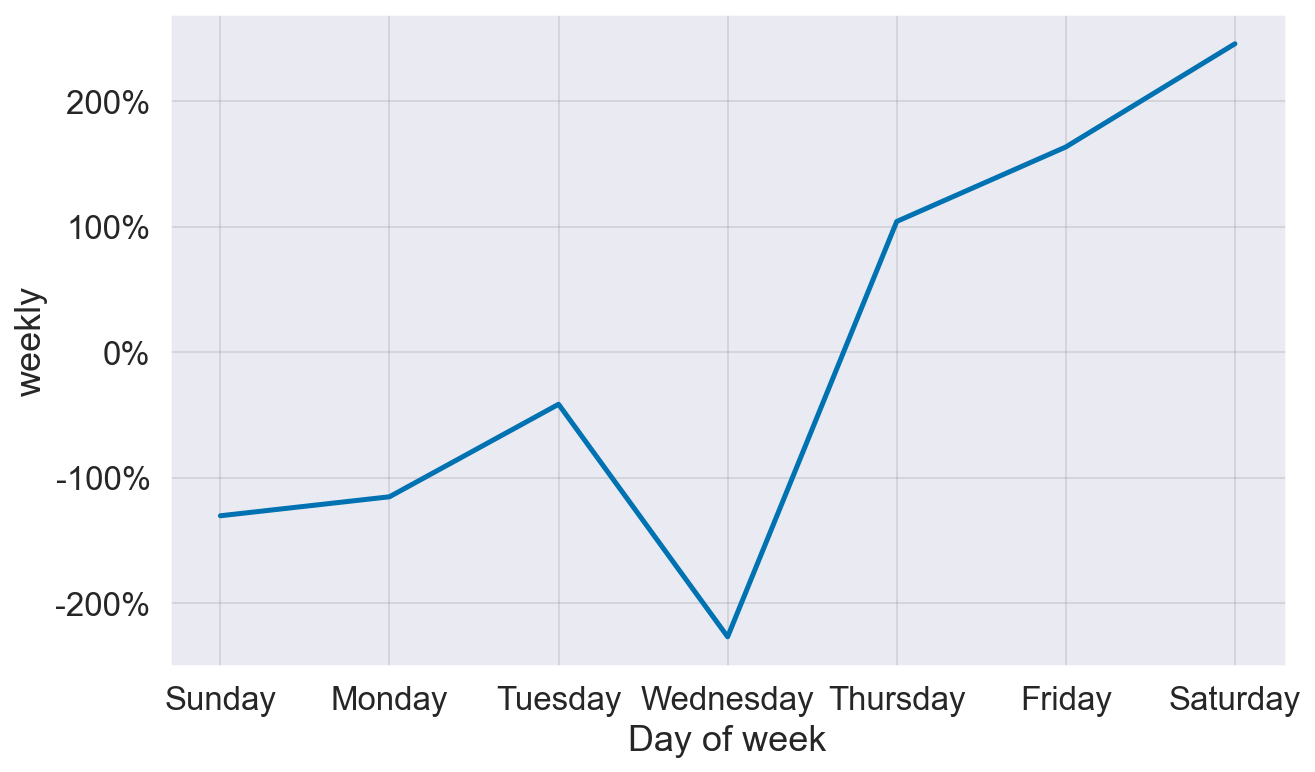

In [33]:
fig_w = plot_weekly(final_prophet)

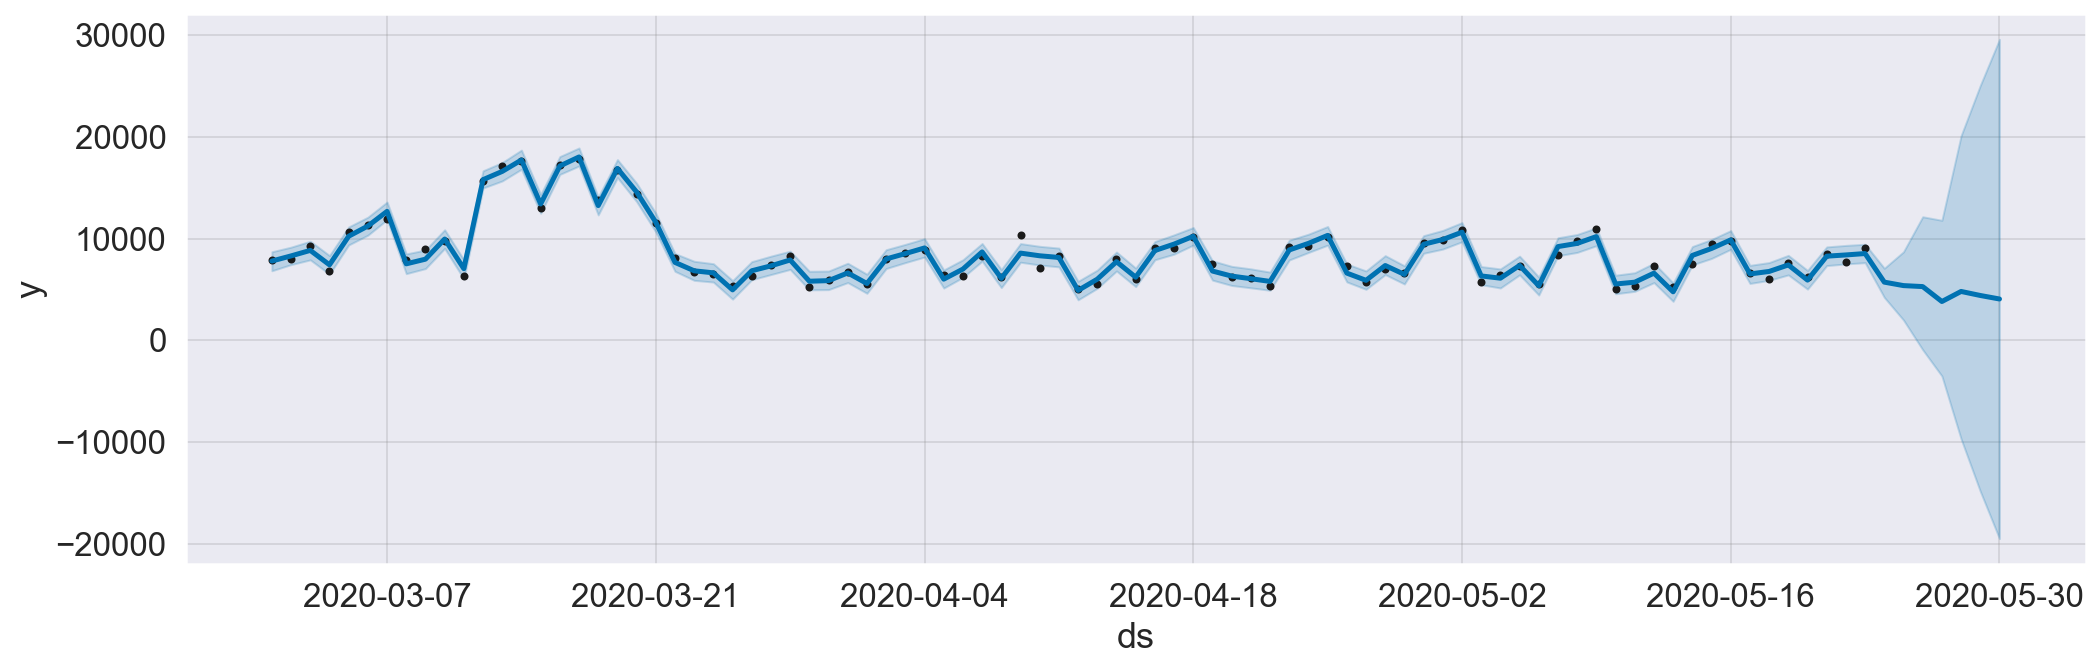

In [34]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet.plot(forecast_final,ax=ax)
plt.show()

In [35]:
df_teste_final= final_prophet.predict(df_274_sale_teste_diario)
iplot(dtview.plot_forecast_as_table(df_teste_final))

In [36]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sale_teste_diario,
                                   df_teste_final,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

# Comparando os dataframes de teste e previsto em escala diária

In [37]:
iplot(dtview.compare_dataframes_with_bar(
    df_274_sale_teste_diario,
    df_teste_final,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [38]:
mape_analysis.append(fm.mape(np.array(df_274_sale_teste_diario.y), np.array(df_teste_final.yhat)))
print("MAPE -----> {}".format(mape_analysis[2]))

MAPE -----> 0.3272175767856876


# Identificando os outliers

In [39]:
#outliers = dtexp.detect_outlier(df_274_sale['y'])
#sorted(outliers)
#lim_inf, lim_sup = dtexp.calculate_iqr_score(outliers)
#print('Outlier inferior {}, outlier superior {}'.format(lim_inf,lim_sup))

In [40]:
dtview.check_outliers_univariate(df_274_sale)

In [41]:
df_sem_outliers = df_274_sale[df_274_sale['y'] < 15689]
df_sem_outliers.info

<bound method DataFrame.info of            ds      y
0  2020-03-01   7942
1  2020-03-02   7974
2  2020-03-03   9237
3  2020-03-04   6825
4  2020-03-05  10643
..        ...    ...
87 2020-05-27   3523
88 2020-05-28   8526
89 2020-05-29   8274
90 2020-05-30  10118
91 2020-05-31   5704

[86 rows x 2 columns]>

###### Outlier são pontos de dados se desviam de forma acentuada dos outros pontos de dados em uma mesma amostra, é chamado de outlier. Qualquer outra observação esperada é rotulada como um inlier"Outliers são os valores em uma série, que se afastam de forma imprevista, dos valores esperados. Isso pode ocorrer em função de características particulares que afetam a variável analisada, erro na transcrição/registo dos valores da variável, etc. A visualização gráfica desses valores em boxplot auxilia a compreender o quanto eles estão distante do valor esperado. A caixa de cor sólida, representa os valores esperados, isto é, o maior conjunto de valores que se repete na série, enquanto os pontos fora da caixa representam os outliers.
`Conforme esclarece Montgomery, os outliers são pontos de dados incomuns que devem ser devidamente identificados para análise futura`

In [42]:
df_274_sem_outliers_treino, df_274_sem_outliers_teste = dtexp.configura_dataframe_treino_teste(df_sem_outliers)
print('-'*60)
print('Shape dataframe de treino --> {}'.format(df_274_sem_outliers_treino.shape))
print('Shape dataframe de teste --> {}'.format(df_274_sem_outliers_teste.shape))
print('-'*60)


------------------------------------------------------------
Shape dataframe de treino --> (78, 2)
Shape dataframe de teste --> (8, 2)
------------------------------------------------------------


In [43]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_treino,
                                   df_274_sem_outliers_teste,
                                   title='Montante de dados de vendas de Treinamento e Teste (sem outliers)',
                                    mode='lines',
                                   name1='Treinamento',
                                   name2='Teste'))

In [44]:
prophet_no_outliers = Prophet()
prophet_no_outliers.fit(df_274_sem_outliers_treino)
future_no_outliers = prophet_no_outliers.make_future_dataframe(periods=7, freq='D')
forecast_no_outliers = prophet_no_outliers.predict(future_no_outliers)

iplot(dtview.plot_forecast_as_table(forecast_no_outliers))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


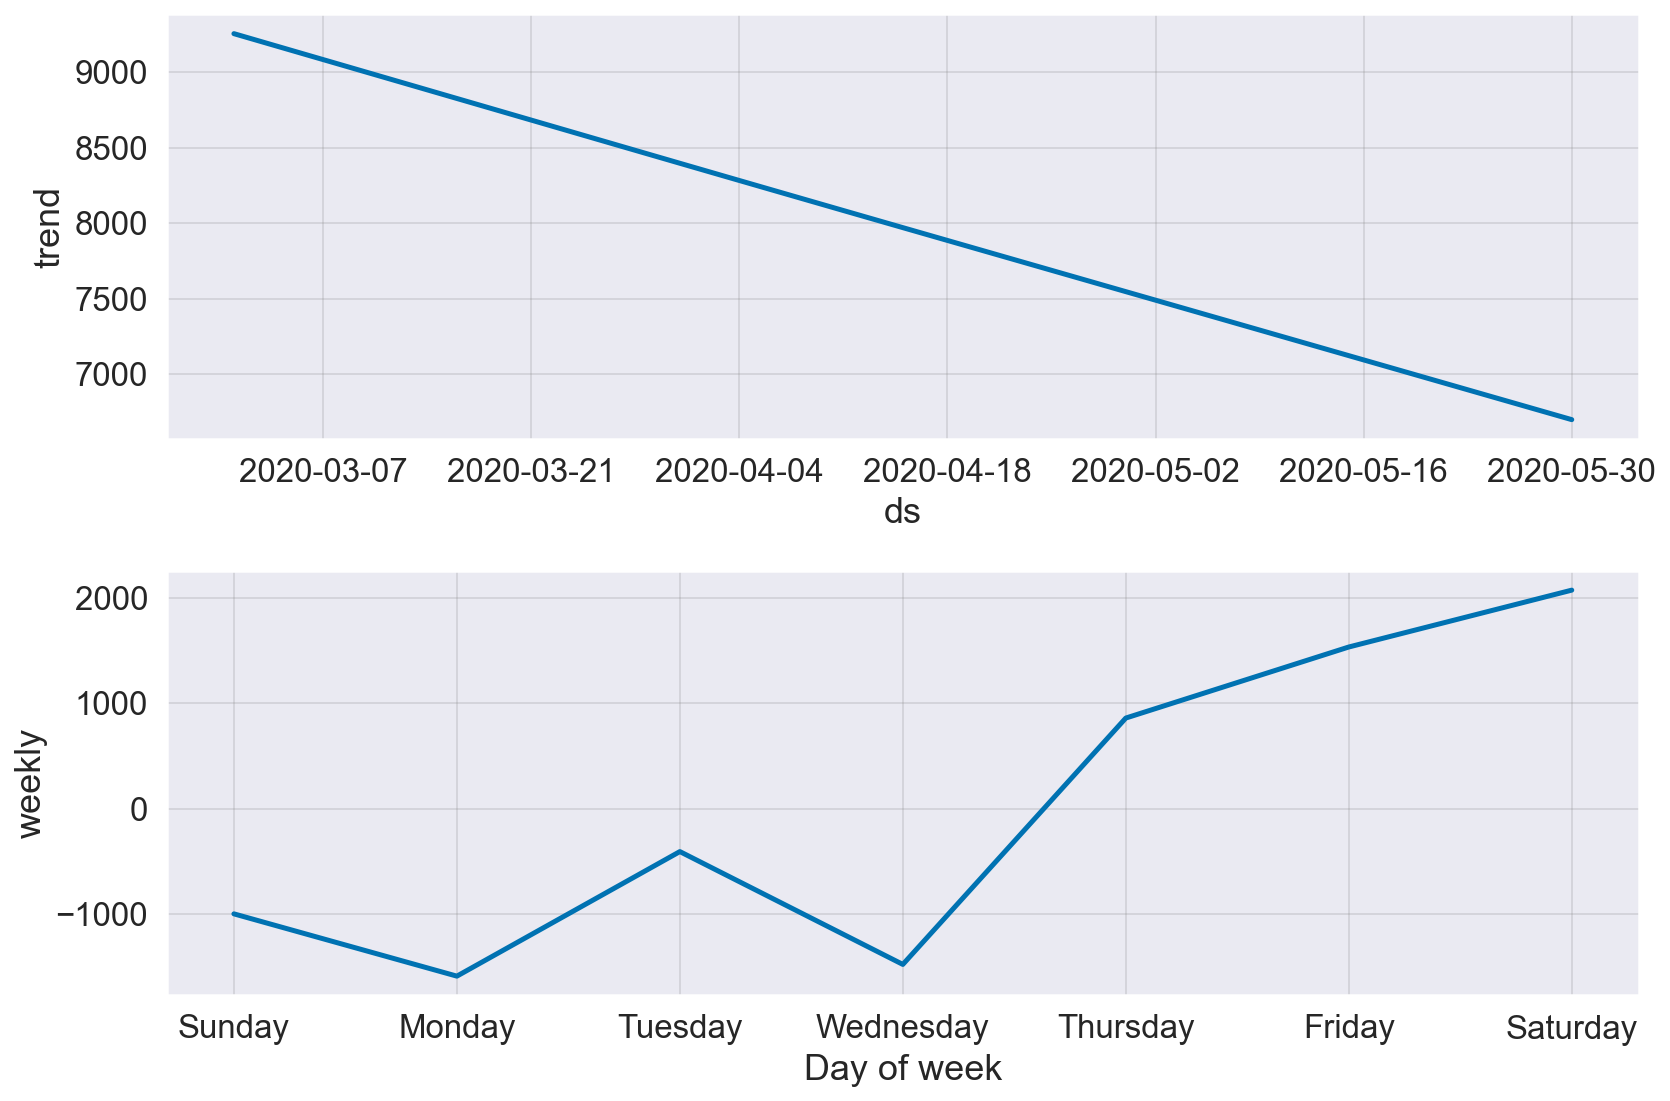

In [45]:
# componentes

fig = prophet_no_outliers.plot_components(forecast_no_outliers, figsize=(12,8))


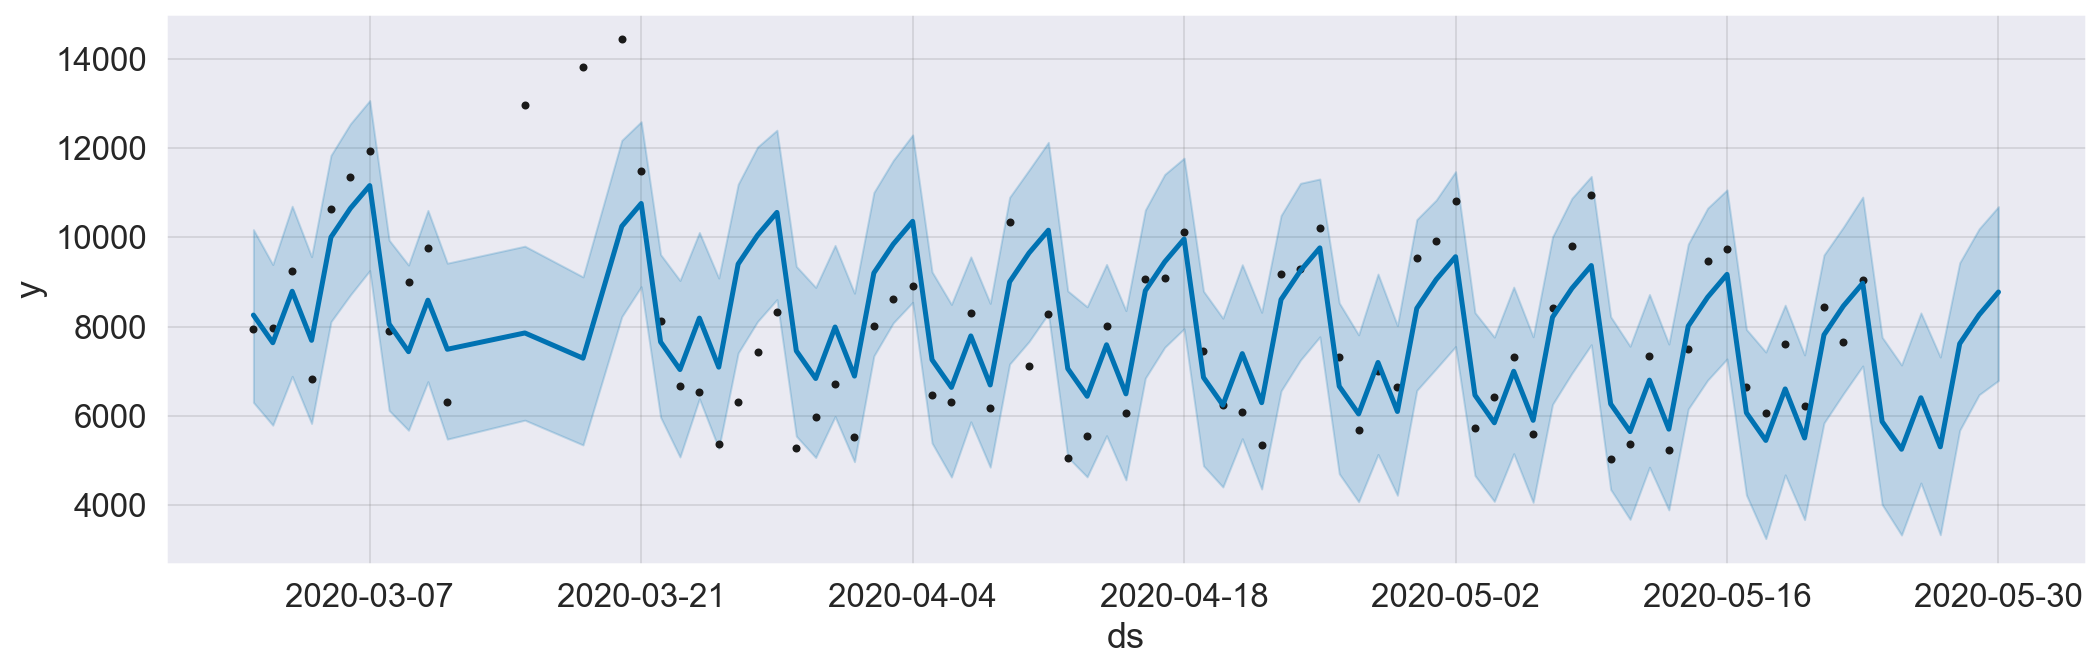

In [46]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_no_outliers.plot(forecast_no_outliers,ax=ax)
plt.show()

In [47]:
df_274_no_outliers_teste_forecast = prophet_no_outliers.predict(df_274_sem_outliers_teste)

In [48]:
iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_274_no_outliers_teste_forecast,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

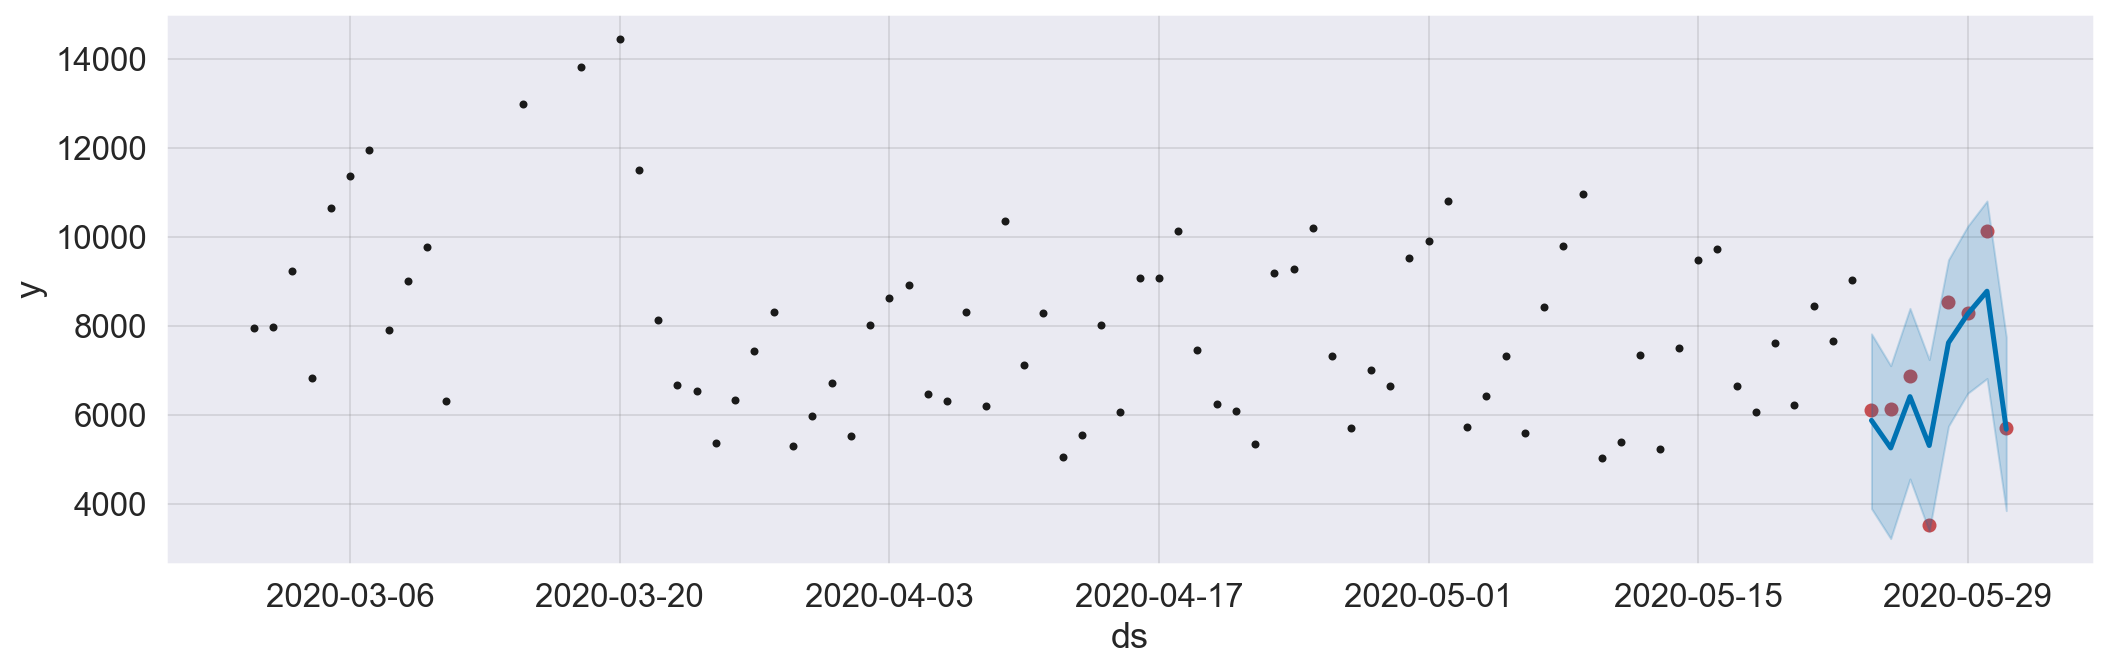

In [49]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds,df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast,ax=ax)
plt.show()

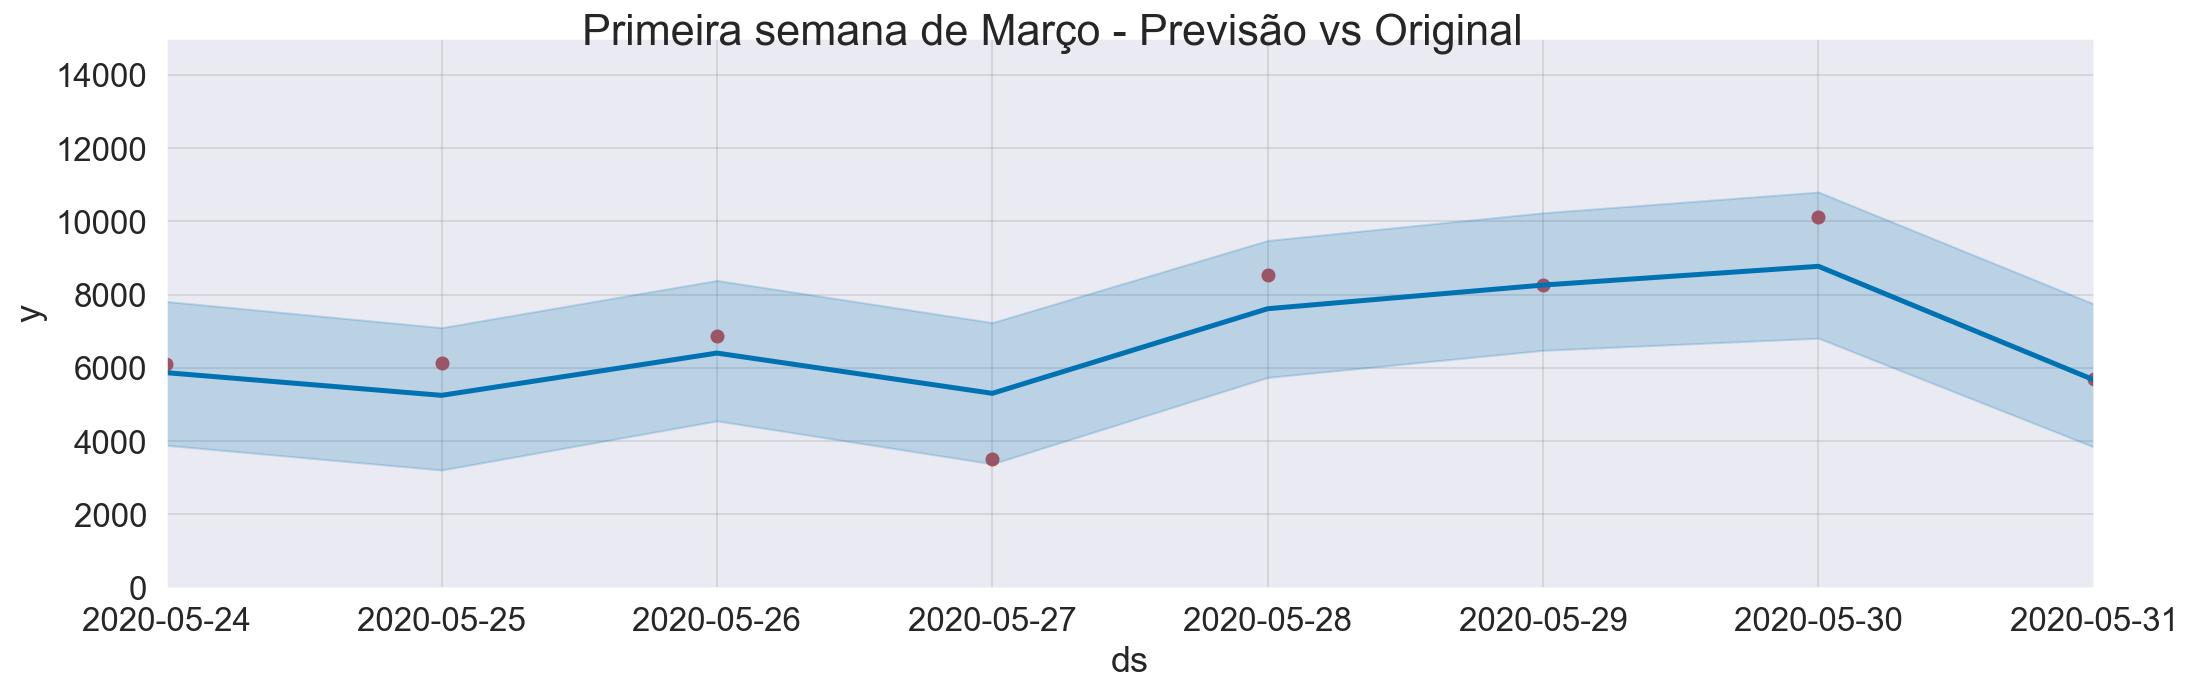

In [50]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_274_sem_outliers_teste.ds, df_274_sem_outliers_teste['y'], color='r')
fig = prophet_no_outliers.plot(df_274_no_outliers_teste_forecast, ax=ax)
ax.set_xbound(lower='2020-05-24', upper='2020-05-31')
ax.set_ylim(0, 15000)
plot = plt.suptitle('Primeira semana de Março - Previsão vs Original')

In [51]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste.y),
                               np.array(df_274_no_outliers_teste_forecast.yhat)))
print("MAPE -----> {}".format(mape_analysis[3]))

MAPE -----> 0.12482887010004967


In [52]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        df_274_no_outliers_teste_forecast,
        nametrace1='Valor Real (sem outliers)',
        nametrace2='Valor Previsto (sem outliers)',
        idx_end=28))

In [53]:
prophet_feriados_s_outliers = Prophet(holidays=dtclean.get_Holiday())

prophet_feriados_s_outliers.add_country_holidays('BR')
prophet_feriados_s_outliers.fit(df_274_sem_outliers_treino)
# Criando as datas futuras previstas pelo prophet
# A frequência especificada em dias (os dados estão em dias)
future_feriados_s_outliers = prophet_feriados_s_outliers.make_future_dataframe(freq='D', periods=7)
# Prevendo os valores
forecast_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)
# Previsão optimizada dos valores
future_feriados_s_outliers = prophet_feriados_s_outliers.predict(future_feriados_s_outliers)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


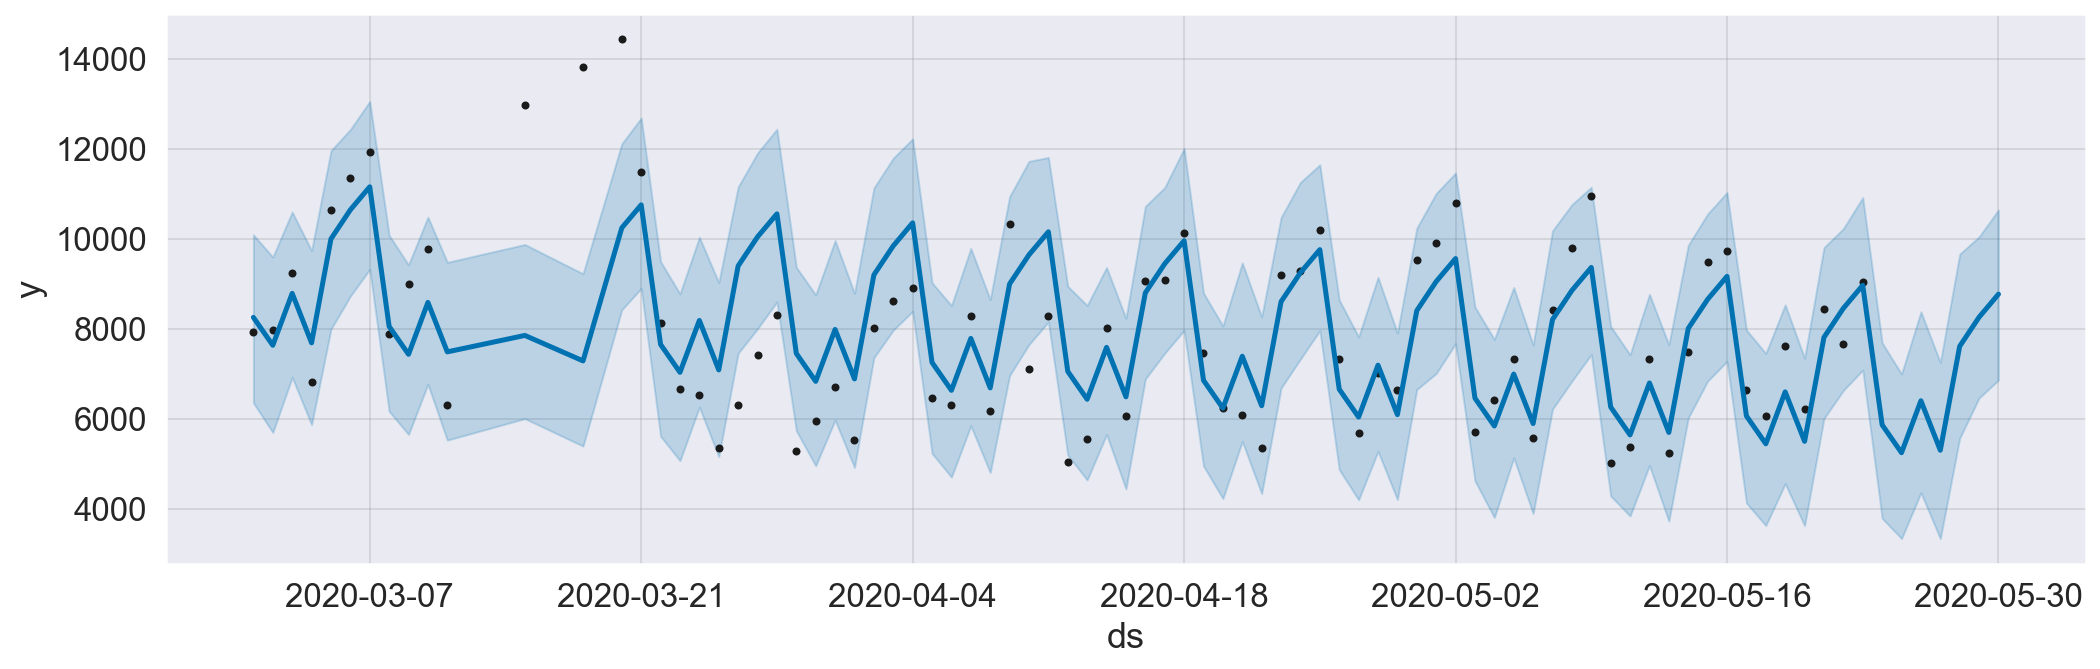

In [54]:
plt,fig_forecast_feriado_s_outliers = dtview.plot_forecast(future_feriados_s_outliers,prophet_feriados_s_outliers,f,ax)
plt.show()

# Visualizando os componentes do modelo

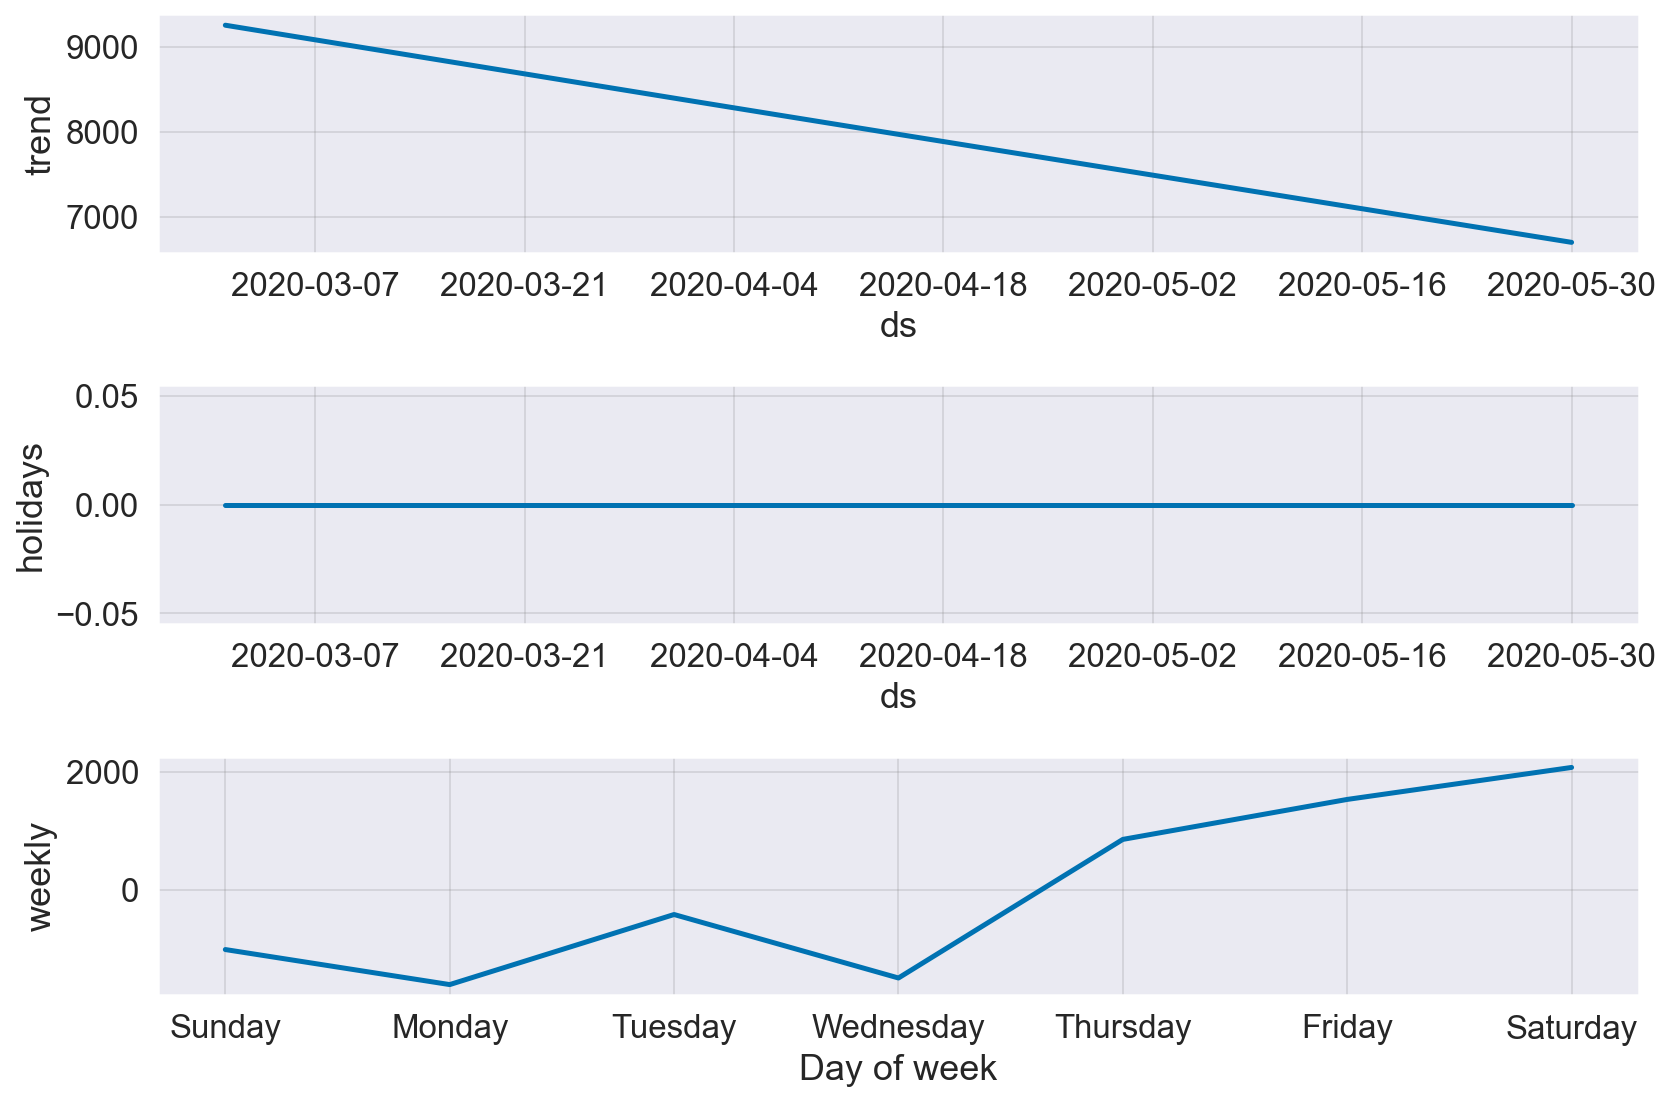

In [55]:
fig_forecast_feriado_s_outliers = prophet_feriados_s_outliers.plot_components(forecast_feriados_s_outliers,figsize=(12,8))

In [56]:
forecast_teste_feriados_s_outliers = prophet_feriados_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(forecast_teste_feriados_s_outliers))

# Visualizar dataframe de teste previsto e original com feriados

In [57]:
iplot(dtview.compare_dataframes_with_scatter(
    df_274_sem_outliers_teste,
    forecast_teste_feriados_s_outliers,
    title='Dados Previsto vs Original última semana de maio/2020',
    mode='lines',
    name1='Original',
    name2='Previsão com feriados',
    is_forecast=True))

In [58]:
iplot(dtview.compare_dataframes_with_bar(
        df_274_sem_outliers_teste,
        forecast_teste_feriados_s_outliers,
        nametrace1='Original',
        nametrace2='Previsão com feriados',
        idx_end=28))

In [59]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(forecast_teste_feriados_s_outliers['yhat'])))
print("MAPE -----> {}".format(mape_analysis[4]))

MAPE -----> 0.12482887010004917


In [ ]:
# Somente utilizar para gerar novo conjunto otimizado de parâmetros atualmente esse conjunto está registado no arquivo:
# 'model_parameters_274_vendas_s_outliers.csv'
dtexp.tuning_model(
    df_274_sem_outliers_treino,
    df_sem_outliers,
    periodo=7,
    frequencia='D',
    loja='274',
    tipo='vendas_s_outliers')

{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062835741250243
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062835741250243
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062835741250243
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.092737388257291
{'changepoint_prior_scale': 15, 'ho

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2858000458502081
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.46207753606002305
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.46207753606002305
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.46207753606002305
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.405297902362672
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.405297902362672
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.405297902362672
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062836704164103
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062836704164103
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2858000474635705
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620927939766739
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620927939766739
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620927939766739
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.4052919972185538
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.4052919972185538
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.4052919972185538
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062971002410209
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5062971002410209
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAP

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.2858000459873031
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620891910304741
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620891910304741
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4620891910304741
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3972871845070516
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3972871845070516
{'changepoint_prior_scale': 15, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3972871845070516
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117759016428206
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117759016428206
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage 

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3036762239154096
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.44756533583011393
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.44756533583011393
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.
INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.44756533583011393
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.314358544865122
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.314358544865122
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 15, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.314358544865122
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117738313127976
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117738313127976
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percentage

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3036762241364428
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4475674128154346
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4475674128154346
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 0.4475674128154346
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3143596006597604
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3143596006597604
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 20, 'n_changepoints': 66, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 25}
Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3143596006597604
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117723810772937
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}
Mean Absolute Percentage Error(MAPE)------------------------------------ 0.5117723810772937
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 25, 'n_changepoints': 30, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25}
Mean Absolute Percenta

INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


Mean Absolute Percentage Error(MAPE)------------------------------------ 1.3036762236895774
{'changepoint_prior_scale': 20.25, 'holidays_prior_scale': 25, 'n_changepoints': 66, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15}


INFO:fbprophet:n_changepoints greater than number of observations. Using 61.


In [60]:
parameters_df_s_outliers = pd.read_csv('model_parameters_274_vendas_s_outliers.csv',sep='\t')
parameters_df_s_outliers = parameters_df_s_outliers.sort_values(by=['MAPE'])
parameters_df_s_outliers = parameters_df_s_outliers.reset_index(drop=True)
parameters_df_s_outliers.drop(['Unnamed: 0'],axis=1,inplace=True)
trace_df_parameters_s_outliers=go.Table(header=dict(values=list(parameters_df_s_outliers[['MAPE','Parameters']])),
                            cells=dict(values=[parameters_df_s_outliers.MAPE,
                                               parameters_df_s_outliers.Parameters]))
data=[trace_df_parameters_s_outliers]
fig_df_parameters_s_outliers=go.Figure(data=data)
iplot(fig_df_parameters_s_outliers)

In [61]:
# Configurando e treinando o modelo com feriados e parâmetros otimizados
final_prophet_s_outliers = Prophet(holidays=dtclean.get_Holiday(),
                      changepoint_prior_scale= 10,
                      holidays_prior_scale = 0.3,
                      n_changepoints = 30,
                      seasonality_mode = 'multiplicative',
                      seasonality_prior_scale = 25,
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_prophet_s_outliers.add_country_holidays(country_name='BR')
final_prophet_s_outliers.fit(df_274_sem_outliers_treino)

In [62]:
future_final_s_outliers = final_prophet_s_outliers.make_future_dataframe(periods=7, freq='D')
forecast_final_s_outliers = final_prophet_s_outliers.predict(future_final_s_outliers)
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

In [63]:
iplot(dtview.plot_forecast_as_table(forecast_final_s_outliers))

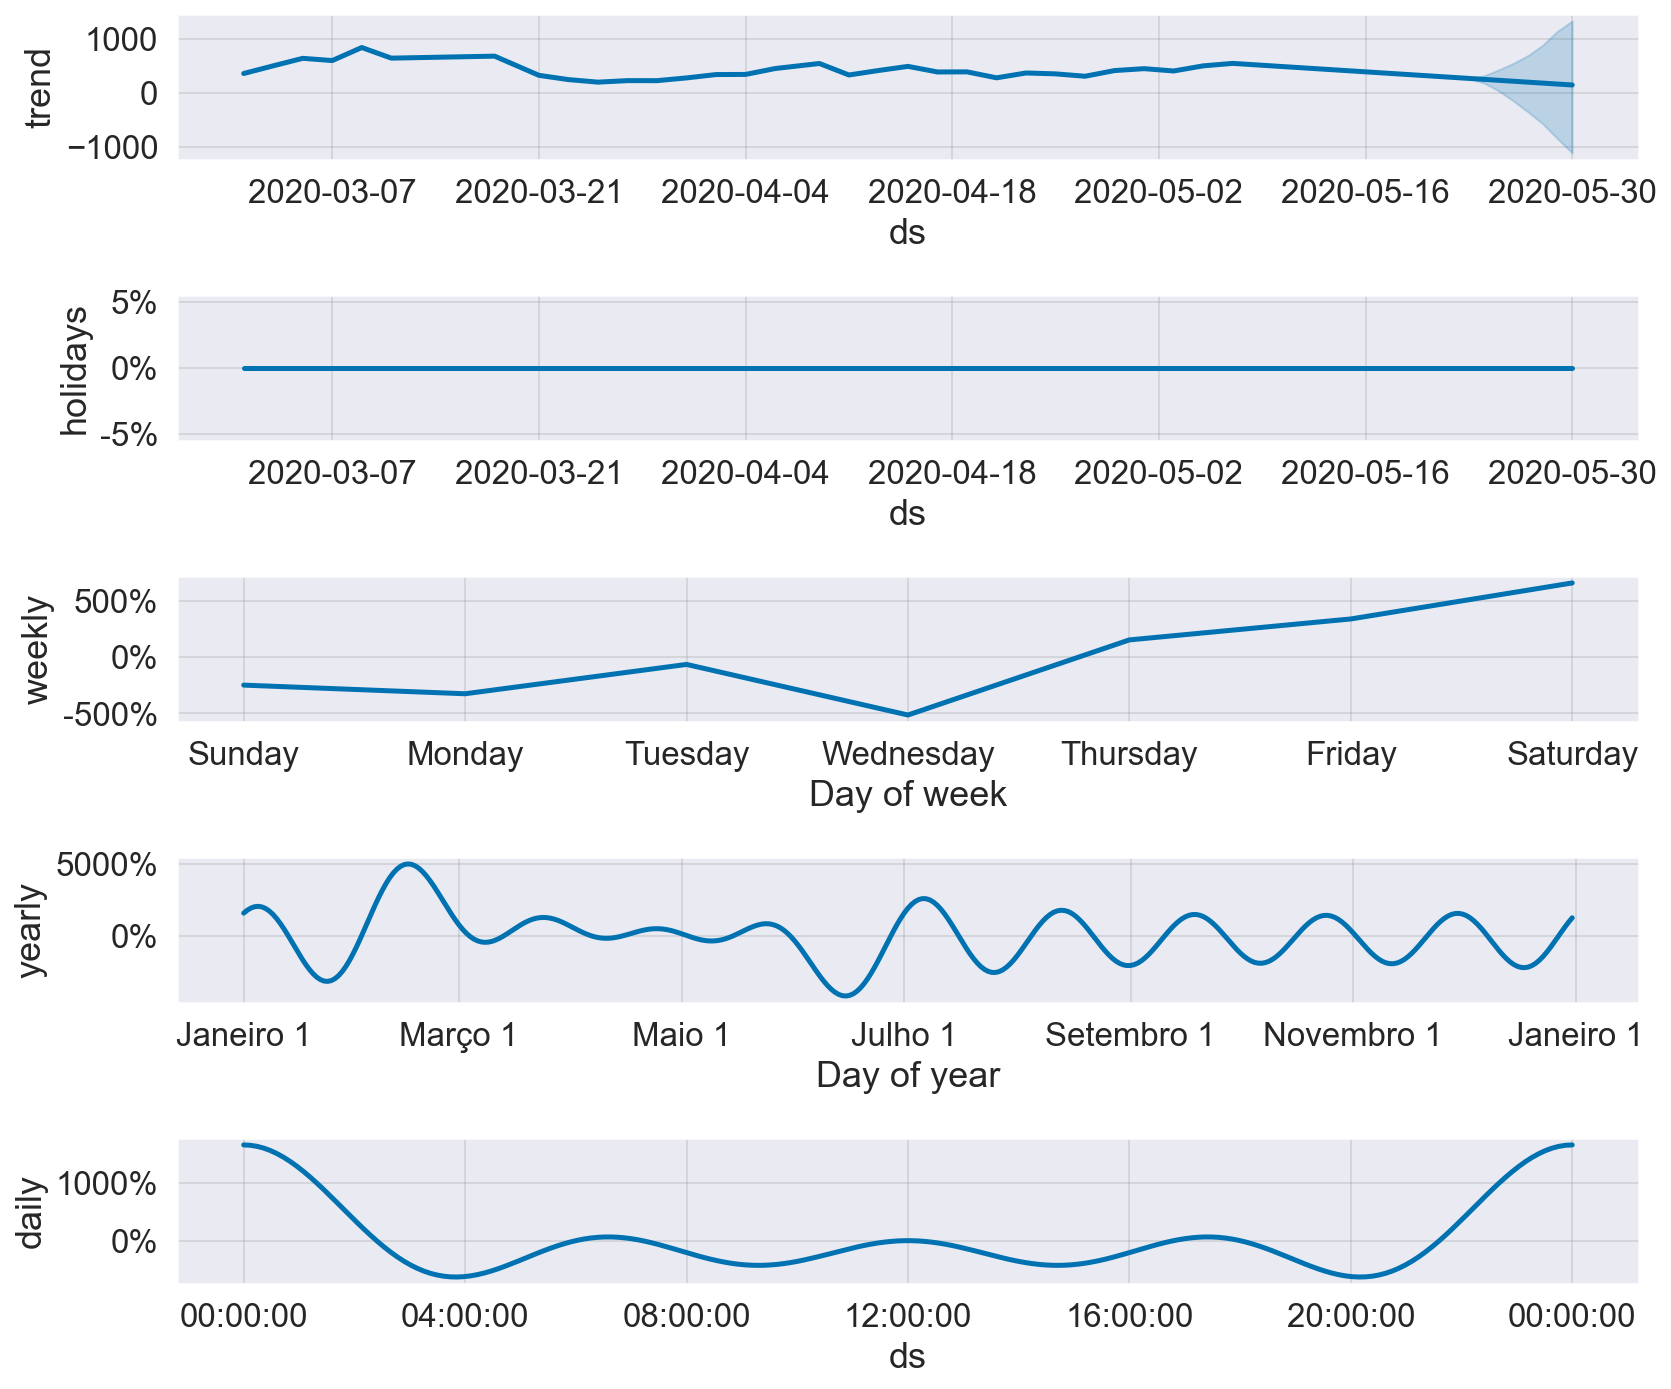

In [64]:
# Plot the components of the model
fig = final_prophet_s_outliers.plot_components(forecast_final_s_outliers, figsize=(12,10))

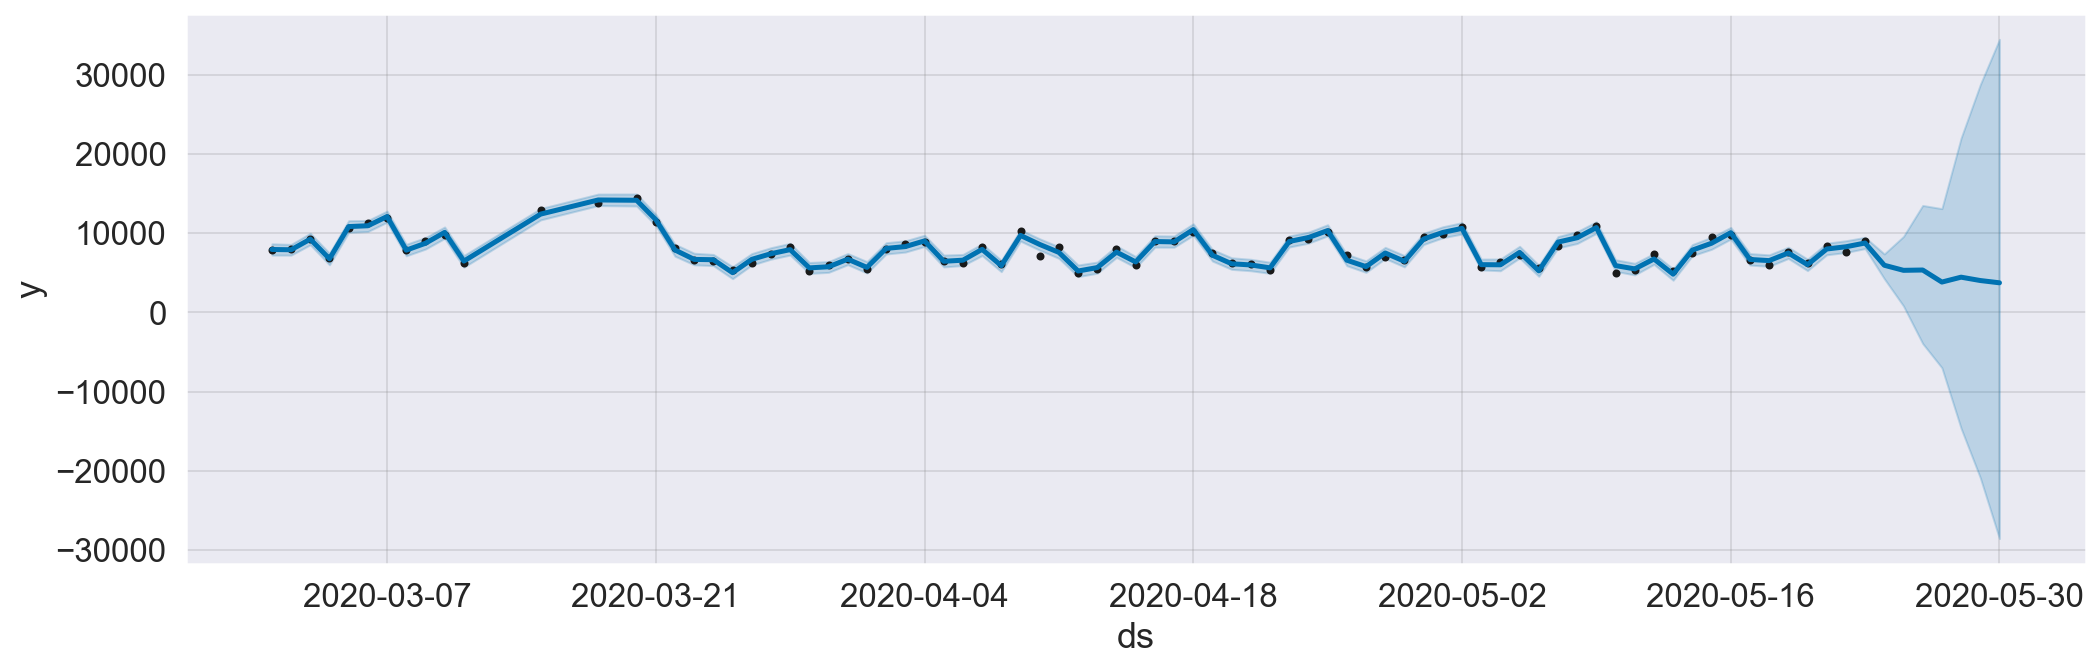

In [65]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = final_prophet_s_outliers.plot(forecast_final_s_outliers,ax=ax)
plt.show()

In [66]:
# Visualizando a tabela prevista

df_teste_final_s_outliers= final_prophet_s_outliers.predict(df_274_sem_outliers_teste)
iplot(dtview.plot_forecast_as_table(df_teste_final_s_outliers))

In [67]:
# Comparando os dataframes em gráfico scatter

iplot(dtview.compare_dataframes_with_scatter(df_274_sem_outliers_teste,
                                   df_teste_final_s_outliers,
                                   title='Previsão de vendas vs Vendas originais realizadas',
                                    mode='lines',
                                   name1='Teste',
                                   name2='Previsto',
                                  is_forecast=True))

In [68]:
# Comparando os dataframes em gráfico de barras

iplot(dtview.compare_dataframes_with_bar(
    df_274_sem_outliers_teste,
    df_teste_final_s_outliers,
    nametrace1='Teste',
    nametrace2='Previsto'))

In [69]:
mape_analysis.append(fm.mape(np.array(df_274_sem_outliers_teste['y']),
                     np.array(df_teste_final_s_outliers['yhat'])))

print("MAPE -----> {}".format(mape_analysis[5]))

MAPE -----> 0.3451345117197922


In [89]:
mape_keys = ['inicial','feriados','parametros','outliers','outliers feriados','outliers params']
mape_vendas_diarias = dict(zip(mape_keys,mape_analysis))
iplot(dtview.plot_results(
    list(mape_vendas_diarias.keys()),
    list(mape_vendas_diarias.values()),
    title='Evolução da métrica MAPE'))


# Normalizing the dataset

In [95]:
# Normalize time series data
from sklearn.preprocessing import MinMaxScaler
# load the dataset and print the first 5 rows
series = df_274_sale
print(series.head())
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 2))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
	print(normalized[i])

          ds      y
0 2020-03-01   7942
1 2020-03-02   7974
2 2020-03-03   9237
3 2020-03-04   6825
4 2020-03-05  10643


TypeError: float() argument must be a string or a number, not 'Timestamp'